In [ ]:
# =============================================================================
# Script for spectral paramaterization and cluster-based analysis of resting 
# EEG data in PD and CTLs.
#
# Uses unpublished resting-state data from 
# Cavanagh, J. F., Kumar, P., Mueller, A. A., Richardson, S. P., & Mueen, A. (2018). 
# Diminished EEG habituation to novel events effectively classifies Parkinson’s patients. 
# Clinical Neurophysiology, 129(2), 409–418. https://doi.org/10.1016/j.clinph.2017.11.023
# 
# Data are available from http://predict.cs.unm.edu/downloads.php, accession d002.
#
# Portions of the loops were based on a script created by waschke
#
# Parts of the script were written to be run on Windows, and others for MACOs. The
# FOOOF loops in particular were written to be run on a Windows machine, and will
# need to be modified to run on a MAC. However, the actual analysis code can be run on Windows
# or MAC.
#
# Created by Douglas Angus, Bond University, 2023.
# =============================================================================

In [18]:
# =============================================================================
import numpy as np
import scipy.io as spio
import sys
import matplotlib.pyplot as plt
from fooof import FOOOFGroup
import fooof
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
import os

def printProgressBar(i,max,postText):
    n_bar =10 #size of progress bar
    j= i/max
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * j):{n_bar}s}] {int(100 * j)}%  {postText}")
    sys.stdout.flush()
        

#This version of the function will reduced differences between groups/subjects, as it calcualtes the avearge across all sites and subs, but does not alter the actual results.        
def check_nans_old(data, nan_policy='mean'):
    """Check an array for nan values, and replace, based on policy."""

    # Find where there are nan values in the data
    nan_inds = np.where(np.isnan(data))

    # Apply desired nan policy to data
    if nan_policy == 'zero':
        data[nan_inds] = 0
    elif nan_policy == 'mean':
        data[nan_inds] = np.nanmean(data)
    else:
        raise ValueError('Nan policy not understood.')

    return data

#Set up functions
def check_nans(data, nan_policy='mean'):
    """Check an array for nan values, and replace, based on policy."""
    outdat = []

    #Get number of rows in first dim 
    for ndim in data:
            datasub = ndim

        # Find where there are nan values in the data
            nan_inds = np.where(np.isnan(datasub))

            # Apply desired nan policy to data
            if nan_policy == 'zero':
                datasub[nan_inds] = 0
            elif nan_policy == 'mean':
                datasub[nan_inds] = np.nanmean(datasub)
            else:
                raise ValueError('Nan policy not understood.')

            outdat.append(datasub)    
        
    data = np.array(outdat)
    return data


In [ ]:
#Specify subjects to be proccessed here. 
good_subs_control = np.array(['894_1',	'908_1',	'8010_1',	'890_1',	'891_1',	'892_1',	'893_1',	'895_1',	'896_1',	'897_1',	'898_1',	'899_1',	'900_1',	'901_1',	'902_1',	'903_1',	'904_1',	'905_1',	'906_1',	'907_1', '910_1',	'911_1',	'912_1',	'913_1',	'914_1',	'8060_1'
])

good_subs_medicated = np.array(['801_1',	'802_2',	'803_2',	'804_1',	'805_1',	'806_2',	'807_2',	'808_2',	'809_1',	'810_1',	'811_1',	'813_2',	'814_1','816_2',	'817_2',	'818_1',	'819_2',	'820_1',	'821_1',	'822_1',	'823_2',	'825_1',	'826_1',	'827_2',	'828_2',	'829_2'
])
    
good_subs_unmedicated = np.array(['801_2',	'802_1',	'803_1',	'804_2',	'805_2',	'806_1',	'807_1',	'808_1',	'809_2',	'810_2',	'811_2',	'813_1',	'814_2',	'816_1',	'817_1',	'818_2',	'819_1',	'820_2',	'821_2',	'822_2',	'823_1',	'825_2',	'826_2',	'827_1',	'828_1',	'829_1'
])


In [ ]:
#Load mat file describing the freqencies for each PSD
freqs = spio.loadmat(os.path.join(os.path.abspath(''),'freqtest.mat'), mdict = None, mat_dtype = True, struct_as_record = False)
#freqs = spio.loadmat(r"G:\OneDrive - Bond University\Aperiodic Signals and Disorders\Parkinsons\Scripts\freqtest.mat", mdict = None, mat_dtype = True, struct_as_record = False)
#freqs = spio.loadmat('/Users/douglasangus/OneDrive - Bond University/Aperiodic Signals and Disorders/Parkinsons/Scripts/freqtest.mat', mdict = None, mat_dtype = True, struct_as_record = False)
freqs = freqs['freqs']
freqs = np.squeeze(freqs,1)

#Define bands for passing to get_band_peak_fg
bands = Bands({'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30]})
      

#Run the FOOOF algorithm over the data. This approach is not ideal, as it involves a lot of duplicated for loops.

#Eyes Open FOOOF
home_dir = os.path.realpath(os.path.join(os.path.abspath(''), '..', 'Data'))
file_prefix = '\EyesOpen_'

#First, run FOOOF over the controls
control_subs_eo = []
control_subs_o_eo = []
control_subs_cf_eo = []

control_subs_alpha_eo = []
control_subs_beta_eo = []
fg_con_eo = []

control_subs_peaks_eo = list()
control_subs_r_eo = []
control_subs_bf_eo = []

for s in range(0, np.size(good_subs_control)):
    sub =good_subs_control[s]

    fname = home_dir + file_prefix + str(sub) + '.mat'
    dat = spio.loadmat(fname, mdict = None, mat_dtype = True, struct_as_record = False)

    ps = dat['SpectraSheetSubject']
    ps = 10**(ps/10)
    
    # first initialize fooof group object
    fg = FOOOFGroup(peak_width_limits=[1, 8], min_peak_height=0.1, max_n_peaks=8,aperiodic_mode = 'fixed')
    freq_range = [2, 40]

    fg.fit(freqs, ps, freq_range, n_jobs = -1)
    exps_temp = fg.get_params('aperiodic_params', 'exponent')
    offset_temp = fg.get_params('aperiodic_params', 'offset')
    peaks_temp = list(fg.get_params('peak_params'))
    osc_peaks = peaks_temp
    r_squ_temp =fg.get_params('r_squared')

    fg.save(home_dir+r'\EyesOpen_FOOOF_'+ str(sub),save_results=True,save_settings=True, save_data=True)

    control_subs_eo.append(exps_temp[np.newaxis])
    control_subs_o_eo.append(offset_temp[np.newaxis])
    control_subs_peaks_eo.append(osc_peaks)
    control_subs_r_eo.append(r_squ_temp[np.newaxis])
    
    fg_con_eo.append(fg)
        
    #Get alpha powers
    cfs_temp = get_band_peak_fg(fg,bands.alpha)
    control_subs_cf_eo.append(cfs_temp[np.newaxis])
    alpha_temp = np.mean(ps[:,np.where(freqs==8)[0][0]:np.where(freqs==13)[0][0]],1)  
    control_subs_alpha_eo.append(alpha_temp[np.newaxis])   
        
    #Get beta powers
    bfs_temp = get_band_peak_fg(fg,bands.beta)
    control_subs_bf_eo.append(bfs_temp[np.newaxis])
    beta_temp = np.mean(ps[:,np.where(freqs==13)[0][0]:np.where(freqs==30)[0][0]],1)
    control_subs_beta_eo.append(beta_temp[np.newaxis])   

    printProgressBar(s,np.size(good_subs_control),sub)

#Then, run FOOOF over the unmedicated parkinsons PSDs
unmed_subs_eo = []
unmed_subs_o_eo = []
unmed_subs_cf_eo = []
unmed_subs_pw_eo = []
unmed_subs_alpha_eo = []
unmed_subs_beta_eo = []
fg_unmed_eo = []

unmed_subs_peaks_eo = list()
unmed_subs_r_eo = []
unmed_subs_bf_eo = []

for s in range(0, np.size(good_subs_unmedicated)):
    sub =good_subs_unmedicated[s]

    fname = home_dir + file_prefix + str(sub) + '.mat'
    dat = spio.loadmat(fname, mdict = None, mat_dtype = True, struct_as_record = False)

    ps = dat['SpectraSheetSubject']
    ps = 10**(ps/10)
    

    # first initialize fooof group object
    fg = FOOOFGroup(peak_width_limits=[1, 8], min_peak_height=0.1, max_n_peaks=8,aperiodic_mode = 'fixed')
    # now initialize input data
    freq_range = [2, 40]

    fg.fit(freqs, ps, freq_range, n_jobs = -1)
    exps_temp = fg.get_params('aperiodic_params', 'exponent')
    
    offset_temp = fg.get_params('aperiodic_params', 'offset')
    peaks_temp = list(fg.get_params('peak_params'))
    osc_peaks = peaks_temp
    r_squ_temp =fg.get_params('r_squared')

    fg.save(home_dir+r'\EyesOpen_FOOOF_'+ str(sub),save_results=True,save_settings=True, save_data=True)

    unmed_subs_eo.append(exps_temp[np.newaxis])
    unmed_subs_o_eo.append(offset_temp[np.newaxis])
    unmed_subs_peaks_eo.append(osc_peaks)
    unmed_subs_r_eo.append(r_squ_temp[np.newaxis])
    
    fg_unmed_eo.append(fg)
    
    #Get alpha powers
    cfs_temp = get_band_peak_fg(fg,bands.alpha)
    unmed_subs_cf_eo.append(cfs_temp[np.newaxis])
    alpha_temp = np.mean(ps[:,np.where(freqs==8)[0][0]:np.where(freqs==13)[0][0]],1)
    unmed_subs_alpha_eo.append(alpha_temp[np.newaxis])   
        
    #Get beta powers
    bfs_temp = get_band_peak_fg(fg,bands.beta)
    unmed_subs_bf_eo.append(bfs_temp[np.newaxis])
    beta_temp = np.mean(ps[:,np.where(freqs==13)[0][0]:np.where(freqs==30)[0][0]],1)
    unmed_subs_beta_eo.append(beta_temp[np.newaxis])   

    printProgressBar(s,np.size(good_subs_unmedicated),sub)

#Then, run FOOOF over the medicated parkinsons PSDs
med_subs_eo = []
med_subs_o_eo = []
med_subs_cf_eo = []
med_subs_pw_eo = []
med_subs_alpha_eo = []
med_subs_beta_eo = []
fg_med_eo = []

med_subs_peaks_eo = list()
med_subs_r_eo = []
med_subs_bf_eo = []

for s in range(0, np.size(good_subs_medicated)):
    sub =good_subs_medicated[s]

    fname = home_dir + file_prefix + str(sub) + '.mat'
    dat = spio.loadmat(fname, mdict = None, mat_dtype = True, struct_as_record = False)

    ps = dat['SpectraSheetSubject']
    ps = 10**(ps/10)

    # first initialize fooof group object
    fg = FOOOFGroup(peak_width_limits=[1, 8], min_peak_height=0.1, max_n_peaks=8,aperiodic_mode = 'fixed')
    # now initialize input data
    freq_range = [2, 40]

    fg.fit(freqs, ps, freq_range, n_jobs = -1)
    exps_temp = fg.get_params('aperiodic_params', 'exponent')
    
    offset_temp = fg.get_params('aperiodic_params', 'offset')
    peaks_temp = list(fg.get_params('peak_params'))
    osc_peaks = peaks_temp
    r_squ_temp =fg.get_params('r_squared')

    fg.save(home_dir+r'\EyesOpen_FOOOF_'+ str(sub),save_results=True,save_settings=True, save_data=True)

    med_subs_eo.append(exps_temp[np.newaxis])
    med_subs_o_eo.append(offset_temp[np.newaxis])
    med_subs_peaks_eo.append(osc_peaks)
    med_subs_r_eo.append(r_squ_temp[np.newaxis])
    
    fg_med_eo.append(fg)
    
    #Get alpha powers
    cfs_temp = get_band_peak_fg(fg,bands.alpha)
    med_subs_cf_eo.append(cfs_temp[np.newaxis])
    alpha_temp = np.mean(ps[:,np.where(freqs==8)[0][0]:np.where(freqs==13)[0][0]],1)
    med_subs_alpha_eo.append(alpha_temp[np.newaxis])   
        
    #Get beta powers
    bfs_temp = get_band_peak_fg(fg,bands.beta)
    med_subs_bf_eo.append(bfs_temp[np.newaxis])
    beta_temp = np.mean(ps[:,np.where(freqs==13)[0][0]:np.where(freqs==30)[0][0]],1)
    med_subs_beta_eo.append(beta_temp[np.newaxis])   

    printProgressBar(s,np.size(good_subs_medicated),sub)


#Eyes Closed FOOOF
file_prefix = '\EyesClosed_'

#First, run FOOOF over the controls
control_subs_ec = []
control_subs_o_ec = []
control_subs_cf_ec = []

control_subs_alpha_ec = []
control_subs_beta_ec = []
fg_con_ec = []

control_subs_peaks_ec = list()
control_subs_r_ec = []
control_subs_bf_ec = []

for s in range(0, np.size(good_subs_control)):
    sub =good_subs_control[s]

    fname = home_dir + file_prefix + str(sub) + '.mat'
    dat = spio.loadmat(fname, mdict = None, mat_dtype = True, struct_as_record = False)

    ps = dat['SpectraSheetSubject']
    ps = 10**(ps/10)

    # first initialize fooof group object
    fg = FOOOFGroup(peak_width_limits=[1, 8], min_peak_height=0.1, max_n_peaks=8,aperiodic_mode = 'fixed')
    # now initialize input data
    freq_range = [2, 40]

    fg.fit(freqs, ps, freq_range, n_jobs = -1)
    exps_temp = fg.get_params('aperiodic_params', 'exponent')
   
    offset_temp = fg.get_params('aperiodic_params', 'offset')
    peaks_temp = list(fg.get_params('peak_params'))
    osc_peaks = peaks_temp
    r_squ_temp =fg.get_params('r_squared')

    fg.save(home_dir+r'\EyesClosed_FOOOF_'+ str(sub),save_results=True,save_settings=True, save_data=True)

    control_subs_ec.append(exps_temp[np.newaxis])
    control_subs_o_ec.append(offset_temp[np.newaxis])
    control_subs_peaks_ec.append(osc_peaks)
    control_subs_r_ec.append(r_squ_temp[np.newaxis])
    
    fg_con_ec.append(fg)
        
    #Get alpha powers
    
    cfs_temp = get_band_peak_fg(fg,bands.alpha)
    control_subs_cf_ec.append(cfs_temp[np.newaxis])
    alpha_temp = np.mean(ps[:,np.where(freqs==8)[0][0]:np.where(freqs==13)[0][0]],1)
    control_subs_alpha_ec.append(alpha_temp[np.newaxis])   
        
    #Get beta powers
    bfs_temp = get_band_peak_fg(fg,bands.beta)
    control_subs_bf_ec.append(bfs_temp[np.newaxis])
    beta_temp = np.mean(ps[:,np.where(freqs==13)[0][0]:np.where(freqs==30)[0][0]],1)
    control_subs_beta_ec.append(beta_temp[np.newaxis])   

    printProgressBar(s,np.size(good_subs_control),sub)

#Then, run FOOOF over the unmedicated parkinsons PSDs
unmed_subs_ec = []
unmed_subs_o_ec = []
unmed_subs_cf_ec = []
unmed_subs_pw_ec = []
unmed_subs_alpha_ec = []
unmed_subs_beta_ec = []
fg_unmed_ec = []

unmed_subs_peaks_ec = list()
unmed_subs_r_ec = []
unmed_subs_bf_ec = []

for s in range(0, np.size(good_subs_unmedicated)):
    sub =good_subs_unmedicated[s]

    fname = home_dir + file_prefix + str(sub) + '.mat'
    dat = spio.loadmat(fname, mdict = None, mat_dtype = True, struct_as_record = False)

    ps = dat['SpectraSheetSubject']
    ps = 10**(ps/10)

    # first initialize fooof group object
    fg = FOOOFGroup(peak_width_limits=[1, 8], min_peak_height=0.1, max_n_peaks=8,aperiodic_mode = 'fixed')
    # now initialize input data
    freq_range = [2, 40]

    fg.fit(freqs, ps, freq_range, n_jobs = -1)
    exps_temp = fg.get_params('aperiodic_params', 'exponent')
    
    offset_temp = fg.get_params('aperiodic_params', 'offset')
    peaks_temp = list(fg.get_params('peak_params'))
    osc_peaks = peaks_temp
    r_squ_temp =fg.get_params('r_squared')

    fg.save(home_dir+r'\EyesClosed_FOOOF_'+ str(sub),save_results=True,save_settings=True, save_data=True)

    unmed_subs_ec.append(exps_temp[np.newaxis])
    unmed_subs_o_ec.append(offset_temp[np.newaxis])
    unmed_subs_peaks_ec.append(osc_peaks)
    unmed_subs_r_ec.append(r_squ_temp[np.newaxis])
    
    fg_unmed_ec.append(fg)
    
    #Get alpha powers
    cfs_temp = get_band_peak_fg(fg,bands.alpha)
    unmed_subs_cf_ec.append(cfs_temp[np.newaxis])
    alpha_temp = np.mean(ps[:,np.where(freqs==8)[0][0]:np.where(freqs==13)[0][0]],1)
    unmed_subs_alpha_ec.append(alpha_temp[np.newaxis])   
        
    #Get beta powers
    bfs_temp = get_band_peak_fg(fg,bands.beta)
    unmed_subs_bf_ec.append(bfs_temp[np.newaxis])
    beta_temp = np.mean(ps[:,np.where(freqs==13)[0][0]:np.where(freqs==30)[0][0]],1)
    unmed_subs_beta_ec.append(beta_temp[np.newaxis])   

    printProgressBar(s,np.size(good_subs_unmedicated),sub)

#Then, run FOOOF over the medicated parkinsons PSDs
med_subs_ec = []
med_subs_o_ec = []
med_subs_cf_ec = []
med_subs_pw_ec = []
med_subs_alpha_ec = []
med_subs_beta_ec = []
fg_med_ec = []

med_subs_peaks_ec = list()
med_subs_r_ec = []
med_subs_bf_ec = []

for s in range(0, np.size(good_subs_medicated)):
    sub =good_subs_medicated[s]

    fname = home_dir + file_prefix + str(sub) + '.mat'
    dat = spio.loadmat(fname, mdict = None, mat_dtype = True, struct_as_record = False)

    ps = dat['SpectraSheetSubject']
    ps = 10**(ps/10)

    # first initialize fooof group object
    fg = FOOOFGroup(peak_width_limits=[1, 8], min_peak_height=0.1, max_n_peaks=8,aperiodic_mode = 'fixed')
    # now initialize input data
    freq_range = [2, 40]

    fg.fit(freqs, ps, freq_range, n_jobs = -1)
    exps_temp = fg.get_params('aperiodic_params', 'exponent')
    
    offset_temp = fg.get_params('aperiodic_params', 'offset')
    peaks_temp = list(fg.get_params('peak_params'))
    osc_peaks = peaks_temp
    r_squ_temp =fg.get_params('r_squared')

    fg.save(home_dir+r'\EyesClosed_FOOOF_'+ str(sub),save_results=True,save_settings=True, save_data=True)

    med_subs_ec.append(exps_temp[np.newaxis])
    med_subs_o_ec.append(offset_temp[np.newaxis])
    med_subs_peaks_ec.append(osc_peaks)
    med_subs_r_ec.append(r_squ_temp[np.newaxis])
    
    fg_med_ec.append(fg)
    
    #Get alpha powers
    cfs_temp = get_band_peak_fg(fg,bands.alpha)
    med_subs_cf_ec.append(cfs_temp[np.newaxis])
    alpha_temp = np.mean(ps[:,np.where(freqs==8)[0][0]:np.where(freqs==13)[0][0]],1)
    med_subs_alpha_ec.append(alpha_temp[np.newaxis])   
        
    #Get beta powers
    bfs_temp = get_band_peak_fg(fg,bands.beta)
    med_subs_bf_ec.append(bfs_temp[np.newaxis])
    beta_temp = np.mean(ps[:,np.where(freqs==13)[0][0]:np.where(freqs==30)[0][0]],1)
    med_subs_beta_ec.append(beta_temp[np.newaxis])   

    printProgressBar(s,np.size(good_subs_medicated),sub)

#Conver to np arrays for saving.
con_test_eo = np.array(control_subs_eo)
con_test_ec = np.array(control_subs_ec)
con_test_o_eo = np.array(control_subs_o_eo)
con_test_o_ec = np.array(control_subs_o_ec)
con_test_alpha_eo = np.array(control_subs_alpha_eo)
con_test_alpha_ec = np.array(control_subs_alpha_ec)
con_test_cf_eo = np.array(control_subs_cf_eo)
con_test_cf_ec = np.array(control_subs_cf_ec)

con_test_peaks_eo = np.array(control_subs_peaks_eo)
con_test_peaks_ec = np.array(control_subs_peaks_ec)
con_test_rsq_eo = np.array(control_subs_r_eo)
con_test_rsq_ec = np.array(control_subs_r_ec)
con_test_bf_eo = np.array(control_subs_bf_eo)
con_test_bf_ec = np.array(control_subs_bf_ec)
con_test_beta_eo = np.array(control_subs_beta_eo)
con_test_beta_ec = np.array(control_subs_beta_ec)

fg_con_eo = fooof.objs.combine_fooofs(fg_con_eo)
fg_con_ec = fooof.objs.combine_fooofs(fg_con_ec)

#Medicated
med_test_eo = np.array(med_subs_eo)
med_test_ec = np.array(med_subs_ec)
med_test_o_eo = np.array(med_subs_o_eo)
med_test_o_ec = np.array(med_subs_o_ec)
med_test_alpha_eo = np.array(med_subs_alpha_eo)
med_test_alpha_ec = np.array(med_subs_alpha_ec)
med_test_cf_eo = np.array(med_subs_cf_eo)
med_test_cf_ec = np.array(med_subs_cf_ec)

med_test_peaks_eo = np.array(med_subs_peaks_eo)
med_test_peaks_ec = np.array(med_subs_peaks_ec)
med_test_rsq_eo = np.array(med_subs_r_eo)
med_test_rsq_ec = np.array(med_subs_r_ec)
med_test_bf_eo = np.array(med_subs_bf_eo)
med_test_bf_ec = np.array(med_subs_bf_ec)
med_test_beta_eo = np.array(med_subs_beta_eo)
med_test_beta_ec = np.array(med_subs_beta_ec)

fg_med_eo = fooof.objs.combine_fooofs(fg_med_eo)
fg_med_ec = fooof.objs.combine_fooofs(fg_med_ec)

#Unmedicated
unmed_test_eo = np.array(unmed_subs_eo)
unmed_test_ec = np.array(unmed_subs_ec)
unmed_test_o_eo = np.array(unmed_subs_o_eo)
unmed_test_o_ec = np.array(unmed_subs_o_ec)
unmed_test_alpha_eo = np.array(unmed_subs_alpha_eo)
unmed_test_alpha_ec = np.array(unmed_subs_alpha_ec)
unmed_test_cf_eo = np.array(unmed_subs_cf_eo)
unmed_test_cf_ec = np.array(unmed_subs_cf_ec)

unmed_test_peaks_eo = np.array(unmed_subs_peaks_eo)
unmed_test_peaks_ec = np.array(unmed_subs_peaks_ec)
unmed_test_rsq_eo = np.array(unmed_subs_r_eo)
unmed_test_rsq_ec = np.array(unmed_subs_r_ec)
unmed_test_bf_eo = np.array(unmed_subs_bf_eo)
unmed_test_bf_ec = np.array(unmed_subs_bf_ec)
unmed_test_beta_eo = np.array(unmed_subs_beta_eo)
unmed_test_beta_ec = np.array(unmed_subs_beta_ec)

fg_unmed_eo = fooof.objs.combine_fooofs(fg_unmed_eo)
fg_unmed_ec = fooof.objs.combine_fooofs(fg_unmed_ec)


#Save files for latter analysis
#Controls
np.save(home_dir+r'\con_subs_ec', con_test_ec)
np.save(home_dir+r'\con_subs_eo', con_test_eo)
np.save(home_dir+r'\con_subs_o_ec', con_test_o_ec)
np.save(home_dir+r'\con_subs_o_eo', con_test_o_eo)
np.save(home_dir+r'\con_subs_pf_ec', con_test_cf_ec)
np.save(home_dir+r'\con_subs_pf_eo', con_test_cf_eo)
np.save(home_dir+r'\con_subs_alpha_ec', con_test_alpha_ec)
np.save(home_dir+r'\con_subs_alpha_eo', con_test_alpha_eo)

np.save(home_dir+r'\con_subs_bf_ec', con_test_bf_ec)
np.save(home_dir+r'\con_subs_bf_eo', con_test_bf_eo)
np.save(home_dir+r'\con_subs_beta_ec', con_test_beta_ec)
np.save(home_dir+r'\con_subs_beta_eo', con_test_beta_eo)
np.save(home_dir+r'\con_subs_peak_ec', con_test_peaks_ec)
np.save(home_dir+r'\con_subs_peak_eo', con_test_peaks_eo)
np.save(home_dir+r'\con_subs_rsq_ec', con_test_rsq_ec)
np.save(home_dir+r'\con_subs_rsq_eo', con_test_rsq_eo)

fg_con_eo.save(home_dir+r'\fg_con_eo',save_results=True,save_settings=True, save_data=True)
fg_con_ec.save(home_dir+r'\fg_con_ec',save_results=True,save_settings=True, save_data=True)

#Medicated
np.save(home_dir+r'\med_subs_ec', med_test_ec)
np.save(home_dir+r'\med_subs_eo', med_test_eo)
np.save(home_dir+r'\med_subs_o_ec', med_test_o_ec)
np.save(home_dir+r'\med_subs_o_eo', med_test_o_eo)
np.save(home_dir+r'\med_subs_pf_ec', med_test_cf_ec)
np.save(home_dir+r'\med_subs_pf_eo', med_test_cf_eo)
np.save(home_dir+r'\med_subs_alpha_ec', med_test_alpha_ec)
np.save(home_dir+r'\med_subs_alpha_eo', med_test_alpha_eo)

np.save(home_dir+r'\med_subs_bf_ec', med_test_bf_ec)
np.save(home_dir+r'\med_subs_bf_eo', med_test_bf_eo)
np.save(home_dir+r'\med_subs_beta_ec', med_test_beta_ec)
np.save(home_dir+r'\med_subs_beta_eo', med_test_beta_eo)
np.save(home_dir+r'\med_subs_peak_ec', med_test_peaks_ec)
np.save(home_dir+r'\med_subs_peak_eo', med_test_peaks_eo)
np.save(home_dir+r'\med_subs_rsq_ec', med_test_rsq_ec)
np.save(home_dir+r'\med_subs_rsq_eo', med_test_rsq_eo)

fg_med_eo.save(home_dir+r'\fg_med_eo',save_results=True,save_settings=True, save_data=True)
fg_med_ec.save(home_dir+r'\fg_med_ec',save_results=True,save_settings=True, save_data=True)

#Unmedicated
np.save(home_dir+r'\unmed_subs_ec', unmed_test_ec)
np.save(home_dir+r'\unmed_subs_eo', unmed_test_eo)
np.save(home_dir+r'\unmed_subs_o_ec', unmed_test_o_ec)
np.save(home_dir+r'\unmed_subs_o_eo', unmed_test_o_eo)
np.save(home_dir+r'\unmed_subs_pf_ec', unmed_test_cf_ec)
np.save(home_dir+r'\unmed_subs_pf_eo', unmed_test_cf_eo)
np.save(home_dir+r'\unmed_subs_alpha_ec', unmed_test_alpha_ec)
np.save(home_dir+r'\unmed_subs_alpha_eo', unmed_test_alpha_eo)

np.save(home_dir+r'\unmed_subs_bf_ec', unmed_test_bf_ec)
np.save(home_dir+r'\unmed_subs_bf_eo', unmed_test_bf_eo)
np.save(home_dir+r'\unmed_subs_beta_ec', unmed_test_beta_ec)
np.save(home_dir+r'\unmed_subs_beta_eo', unmed_test_beta_eo)
np.save(home_dir+r'\unmed_subs_peak_ec', unmed_test_peaks_ec)
np.save(home_dir+r'\unmed_subs_peak_eo', unmed_test_peaks_eo)
np.save(home_dir+r'\unmed_subs_rsq_ec', unmed_test_rsq_ec)
np.save(home_dir+r'\unmed_subs_rsq_eo', unmed_test_rsq_eo)

fg_unmed_eo.save(home_dir+r'\fg_unmed_eo',save_results=True,save_settings=True, save_data=True)
fg_unmed_ec.save(home_dir+r'\fg_unmed_ec',save_results=True,save_settings=True, save_data=True)

In [2]:
#Load data in Windows.
home_dir = os.path.realpath(os.path.join(os.path.abspath(''), '..', 'Data'))

con_test_eo = np.load(home_dir+'\con_subs_eo.npy')
con_test_ec = np.load(home_dir+'\con_subs_ec.npy')
con_test_cf_eo = np.load(home_dir+'\con_subs_pf_eo.npy')
con_test_cf_ec = np.load(home_dir+'\con_subs_pf_ec.npy')
con_test_o_eo = np.load(home_dir+'\con_subs_o_eo.npy')
con_test_o_ec = np.load(home_dir+'\con_subs_o_ec.npy')
con_test_alpha_eo = np.load(home_dir+'\con_subs_alpha_eo.npy')
con_test_alpha_ec = np.load(home_dir+'\con_subs_alpha_ec.npy')

con_test_bf_eo = np.load(home_dir+'\con_subs_bf_eo.npy')
con_test_bf_ec = np.load(home_dir+'\con_subs_bf_ec.npy')
con_test_beta_eo = np.load(home_dir+'\con_subs_beta_eo.npy')
con_test_beta_ec = np.load(home_dir+'\con_subs_beta_ec.npy')
con_test_peaks_eo = np.load(home_dir+'\con_subs_peak_eo.npy',allow_pickle=True)
con_test_peaks_ec = np.load(home_dir+'\con_subs_peak_ec.npy',allow_pickle=True)
con_test_rsq_eo = np.load(home_dir+'\con_subs_rsq_eo.npy')
con_test_rsq_ec = np.load(home_dir+'\con_subs_rsq_ec.npy')

fg_con_eo = FOOOFGroup()
fg_con_ec = FOOOFGroup()
fg_con_eo.load(home_dir+r'\fg_con_eo')
fg_con_ec.load(home_dir+r'\fg_con_ec')


#Medicated
med_test_eo = np.load(home_dir+'\med_subs_eo.npy')
med_test_ec = np.load(home_dir+'\med_subs_ec.npy')
med_test_cf_eo = np.load(home_dir+'\med_subs_pf_eo.npy')
med_test_cf_ec = np.load(home_dir+'\med_subs_pf_ec.npy')
med_test_o_eo = np.load(home_dir+'\med_subs_o_eo.npy')
med_test_o_ec = np.load(home_dir+'\med_subs_o_ec.npy')
med_test_alpha_eo = np.load(home_dir+'\med_subs_alpha_eo.npy')
med_test_alpha_ec = np.load(home_dir+'\med_subs_alpha_ec.npy')

med_test_bf_eo = np.load(home_dir+'\med_subs_bf_eo.npy')
med_test_bf_ec = np.load(home_dir+'\med_subs_bf_ec.npy')
med_test_beta_eo = np.load(home_dir+'\med_subs_beta_eo.npy')
med_test_beta_ec = np.load(home_dir+'\med_subs_beta_ec.npy')
med_test_peaks_eo = np.load(home_dir+'\med_subs_peak_eo.npy',allow_pickle=True)
med_test_peaks_ec = np.load(home_dir+'\med_subs_peak_ec.npy',allow_pickle=True)
med_test_rsq_eo = np.load(home_dir+'\med_subs_rsq_eo.npy')
med_test_rsq_ec = np.load(home_dir+'\med_subs_rsq_ec.npy')


fg_med_eo = FOOOFGroup()
fg_med_ec = FOOOFGroup()
fg_med_eo.load(home_dir+r'\fg_med_eo')
fg_med_ec.load(home_dir+r'\fg_med_ec')

#Unmedicated
unmed_test_eo = np.load(home_dir+r'\unmed_subs_eo.npy')
unmed_test_ec = np.load(home_dir+r'\unmed_subs_ec.npy')
unmed_test_cf_eo = np.load(home_dir+r'\unmed_subs_pf_eo.npy')
unmed_test_cf_ec = np.load(home_dir+r'\unmed_subs_pf_ec.npy')
unmed_test_o_eo = np.load(home_dir+r'\unmed_subs_o_eo.npy')
unmed_test_o_ec = np.load(home_dir+r'\unmed_subs_o_ec.npy')
unmed_test_alpha_eo = np.load(home_dir+r'\unmed_subs_alpha_eo.npy')
unmed_test_alpha_ec = np.load(home_dir+r'\unmed_subs_alpha_ec.npy')


unmed_test_bf_eo = np.load(home_dir+r'\unmed_subs_bf_eo.npy')
unmed_test_bf_ec = np.load(home_dir+r'\unmed_subs_bf_ec.npy')
unmed_test_beta_eo = np.load(home_dir+r'\unmed_subs_beta_eo.npy')
unmed_test_beta_ec = np.load(home_dir+r'\unmed_subs_beta_ec.npy')
unmed_test_peaks_eo = np.load(home_dir+r'\unmed_subs_peak_eo.npy',allow_pickle=True)
unmed_test_peaks_ec = np.load(home_dir+r'\unmed_subs_peak_ec.npy',allow_pickle=True)
unmed_test_rsq_eo = np.load(home_dir+r'\unmed_subs_rsq_eo.npy')
unmed_test_rsq_ec = np.load(home_dir+r'\unmed_subs_rsq_ec.npy')


fg_unmed_eo = FOOOFGroup()
fg_unmed_ec = FOOOFGroup()
fg_unmed_eo.load(home_dir+r'\fg_unmed_eo')
fg_unmed_ec.load(home_dir+r'\fg_unmed_ec')

In [14]:
#For MAC
home_dir = os.path.realpath(os.path.join(os.path.abspath(''), '..', 'Data'))

con_test_eo = np.load(home_dir+'/con_subs_eo.npy')
con_test_ec = np.load(home_dir+'/con_subs_ec.npy')
con_test_cf_eo = np.load(home_dir+'/con_subs_pf_eo.npy')
con_test_cf_ec = np.load(home_dir+'/con_subs_pf_ec.npy')
con_test_o_eo = np.load(home_dir+'/con_subs_o_eo.npy')
con_test_o_ec = np.load(home_dir+'/con_subs_o_ec.npy')
con_test_alpha_eo = np.load(home_dir+'/con_subs_alpha_eo.npy')
con_test_alpha_ec = np.load(home_dir+'/con_subs_alpha_ec.npy')

con_test_bf_eo = np.load(home_dir+'/con_subs_bf_eo.npy')
con_test_bf_ec = np.load(home_dir+'/con_subs_bf_ec.npy')
con_test_beta_eo = np.load(home_dir+'/con_subs_beta_eo.npy')
con_test_beta_ec = np.load(home_dir+'/con_subs_beta_ec.npy')

con_test_peaks_eo = np.load(home_dir+'/con_subs_peak_eo.npy',allow_pickle=True)
con_test_peaks_ec = np.load(home_dir+'/con_subs_peak_ec.npy',allow_pickle=True)
con_test_rsq_eo = np.load(home_dir+'/con_subs_rsq_eo.npy')
con_test_rsq_ec = np.load(home_dir+'/con_subs_rsq_ec.npy')

fg_con_eo = FOOOFGroup()
fg_con_ec = FOOOFGroup()
fg_con_eo.load(home_dir+r'/fg_con_eo')
fg_con_ec.load(home_dir+r'/fg_con_ec')

#Medicated
med_test_eo = np.load(home_dir+'/med_subs_eo.npy')
med_test_ec = np.load(home_dir+'/med_subs_ec.npy')
med_test_cf_eo = np.load(home_dir+'/med_subs_pf_eo.npy')
med_test_cf_ec = np.load(home_dir+'/med_subs_pf_ec.npy')
med_test_o_eo = np.load(home_dir+'/med_subs_o_eo.npy')
med_test_o_ec = np.load(home_dir+'/med_subs_o_ec.npy')
med_test_alpha_eo = np.load(home_dir+'/med_subs_alpha_eo.npy')
med_test_alpha_ec = np.load(home_dir+'/med_subs_alpha_ec.npy')


med_test_bf_eo = np.load(home_dir+'/med_subs_bf_eo.npy')
med_test_bf_ec = np.load(home_dir+'/med_subs_bf_ec.npy')
med_test_beta_eo = np.load(home_dir+'/med_subs_beta_eo.npy')
med_test_beta_ec = np.load(home_dir+'/med_subs_beta_ec.npy')

fg_med_eo = FOOOFGroup()
fg_med_ec = FOOOFGroup()
fg_med_eo.load(home_dir+r'/fg_med_eo')
fg_med_ec.load(home_dir+r'/fg_med_ec')

#Unmedicated
unmed_test_eo = np.load(home_dir+r'/unmed_subs_eo.npy')
unmed_test_ec = np.load(home_dir+r'/unmed_subs_ec.npy')
unmed_test_cf_eo = np.load(home_dir+r'/unmed_subs_pf_eo.npy')
unmed_test_cf_ec = np.load(home_dir+r'/unmed_subs_pf_ec.npy')
unmed_test_o_eo = np.load(home_dir+r'/unmed_subs_o_eo.npy')
unmed_test_o_ec = np.load(home_dir+r'/unmed_subs_o_ec.npy')
unmed_test_alpha_eo = np.load(home_dir+r'/unmed_subs_alpha_eo.npy')
unmed_test_alpha_ec = np.load(home_dir+r'/unmed_subs_alpha_ec.npy')

unmed_test_bf_eo = np.load(home_dir+r'/unmed_subs_bf_eo.npy')
unmed_test_bf_ec = np.load(home_dir+r'/unmed_subs_bf_ec.npy')
unmed_test_beta_eo = np.load(home_dir+r'/unmed_subs_beta_eo.npy')
unmed_test_beta_ec = np.load(home_dir+r'/unmed_subs_beta_ec.npy')

fg_unmed_eo = FOOOFGroup()
fg_unmed_ec = FOOOFGroup()
fg_unmed_eo.load(home_dir+r'/fg_unmed_eo')
fg_unmed_ec.load(home_dir+r'/fg_unmed_ec')

In [19]:
import mne
import numpy as np
from mne.stats import permutation_cluster_test
from mne.stats import ttest_1samp_no_p
from mne.stats import permutation_cluster_1samp_test
from scipy import stats as stats

good_subs_control = np.array(['894_1',	'908_1',	'8010_1',	'890_1',	'891_1',	'892_1',	'893_1',	'895_1',	'896_1',	'897_1',	'898_1',	'899_1',	'900_1',	'901_1',	'902_1',	'903_1',	'904_1',	'905_1',	'906_1',	'907_1', '910_1',	'911_1',	'912_1',	'913_1',	'914_1',	'8060_1'
])

good_subs_medicated = np.array(['801_1',	'802_2',	'803_2',	'804_1',	'805_1',	'806_2',	'807_2',	'808_2',	'809_1',	'810_1',	'811_1',	'813_2',	'814_1','816_2',	'817_2',	'818_1',	'819_2',	'820_1',	'821_1',	'822_1',	'823_2',	'825_1',	'826_1',	'827_2',	'828_2',	'829_2'
])
    
good_subs_unmedicated = np.array(['801_2',	'802_1',	'803_1',	'804_2',	'805_2',	'806_1',	'807_1',	'808_1',	'809_2',	'810_2',	'811_2',	'813_1',	'814_2',	'816_1',	'817_1',	'818_2',	'819_1',	'820_2',	'821_2',	'822_2',	'823_1',	'825_2',	'826_2',	'827_1',	'828_1',	'829_1'
])
   
seed = 1234

#Load a processed file from EEGLAB so we can construct an MNE info variable.
chan_info = mne.io.read_raw_eeglab(os.path.join(os.path.abspath(''),"info_file.set"), preload = True)

#Calculate adjacent sensors
adjacency, _ = mne.channels.find_ch_adjacency(chan_info.info, "eeg")

#Set paramters for t-tests
p_threshold = 0.05
t_threshold_between = -stats.distributions.t.ppf(p_threshold / 2., (good_subs_control.size+good_subs_unmedicated.size) - 2)
t_threshold_ws = -stats.distributions.t.ppf(p_threshold / 2., good_subs_medicated.size - 1)

#Time to get out alpha power! The last index ensures that it is power that gets extracted vs peak frequency (index 0) or bandwidth (index 2)
con_nans_eo = check_nans(con_test_cf_eo[:,:,:,1])
con_nans_ec = check_nans(con_test_cf_ec[:,:,:,1])
med_nans_eo = check_nans(med_test_cf_eo[:,:,:,1])
med_nans_ec = check_nans(med_test_cf_ec[:,:,:,1])
unmed_nans_eo = check_nans(unmed_test_cf_eo[:,:,:,1])
unmed_nans_ec = check_nans(unmed_test_cf_ec[:,:,:,1])

#Now beta powers
con_nans_bf_eo = check_nans(con_test_bf_eo[:,:,:,1])
con_nans_bf_ec = check_nans(con_test_bf_ec[:,:,:,1])
med_nans_bf_eo = check_nans(med_test_bf_eo[:,:,:,1])
med_nans_bf_ec = check_nans(med_test_bf_ec[:,:,:,1])
unmed_nans_bf_eo = check_nans(unmed_test_bf_eo[:,:,:,1])
unmed_nans_bf_ec = check_nans(unmed_test_bf_ec[:,:,:,1])

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/1636812217.py:21: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  chan_info = mne.io.read_raw_eeglab(os.path.join(os.path.abspath(''),"info_file.set"), preload = True)


In [20]:
# %%% Run permutation tests for OFF vs CTL, exponent %%%
#Eyes open
T_obs_eo_unmed, clusters_eo_unmed, cluster_p_values_eo_unmed, H0_eo_unmed = \
    permutation_cluster_test([con_test_eo, unmed_test_eo], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

#Eyes closed
T_obs_ec_unmed, clusters_ec_unmed, cluster_p_values_ec_unmed, H0_ec_unmed = \
    permutation_cluster_test([con_test_ec, unmed_test_ec], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

stat_fun(H1): min=-2.818803 max=0.411127
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.126122 max=-0.637270
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [21]:
# %%% Run permutation tests for OFF vs CTL, offset %%%

#Eyes open
T_obs_o_eo_unmed, clusters_o_eo_unmed, cluster_p_values_o_eo_unmed, H0_o_eo_unmed = \
    permutation_cluster_test([con_test_o_eo, unmed_test_o_eo], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)
#Eyes closed
T_obs_o_ec_unmed, clusters_o_ec_unmed, cluster_p_values_o_ec_unmed, H0_o_ec_unmed = \
    permutation_cluster_test([con_test_o_ec, unmed_test_o_ec], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

stat_fun(H1): min=-4.889139 max=-2.091822
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.014035 max=-2.709719
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [22]:
# %%% Run permutation tests for OFF vs CTL, total alpha %%%

#Eyes open  
T_obs_alpha_eo_unmed, clusters_alpha_eo_unmed, cluster_p_values_alpha_eo_unmed, H0_alpha_eo_unmed = \
    permutation_cluster_test([con_test_alpha_eo, unmed_test_alpha_eo], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

#Eyes closed    
T_obs_alpha_ec_unmed, clusters_alpha_ec_unmed, cluster_p_values_alpha_ec_unmed, H0_alpha_ec_unmed = \
   permutation_cluster_test([con_test_alpha_ec, unmed_test_alpha_ec], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

stat_fun(H1): min=-3.391389 max=-1.651880
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.859012 max=-1.190286
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [24]:
# %%% Run permutation tests for OFF vs CTL, total beta %%%

#Eyes open  
T_obs_beta_eo_unmed, clusters_beta_eo_unmed, cluster_p_values_beta_eo_unmed, H0_beta_eo_unmed = \
    permutation_cluster_test([con_test_beta_eo, unmed_test_beta_eo], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

#Eyes closed    
T_obs_beta_ec_unmed, clusters_beta_ec_unmed, cluster_p_values_beta_ec_unmed, H0_beta_ec_unmed = \
   permutation_cluster_test([con_test_beta_ec, unmed_test_beta_ec], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

stat_fun(H1): min=-3.472526 max=-0.667720
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.366498 max=-0.712872
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [23]:
# %%% Run permutation tests for OFF vs CTL, param alpha power %%%

#Eyes open
T_obs_cw_eo_unmed, clusters_cw_eo_unmed, cluster_p_values_cw_eo_unmed, H0_cw_eo_unmed = \
    permutation_cluster_test([con_nans_eo, unmed_nans_eo], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)
   
#Eyes closed    
T_obs_cw_ec_unmed, clusters_cw_ec_unmed, cluster_p_values_cw_ec_unmed, H0_cw_ec_unmed = \
   permutation_cluster_test([con_nans_ec, unmed_nans_ec], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)  

stat_fun(H1): min=-3.664395 max=-0.814167
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.360079 max=-0.039512
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [25]:
# %%% Run permutation tests for OFF vs CTL, param beta power %%%

T_obs_bw_eo_unmed, clusters_bw_eo_unmed, cluster_p_values_bw_eo_unmed, H0_bw_eo_unmed = \
    permutation_cluster_test([con_nans_bf_eo, unmed_nans_bf_eo], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)
    
T_obs_bw_ec_unmed, clusters_bw_ec_unmed, cluster_p_values_bw_ec_unmed, H0_bw_ec_unmed = \
   permutation_cluster_test([con_nans_bf_ec, unmed_nans_bf_ec], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

stat_fun(H1): min=-0.332311 max=2.881844
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-0.254731 max=2.909160
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [26]:
# %%% Run permutation tests for ON vs CTL, exponent %%%

#Eyes open
T_obs_eo_med, clusters_eo_med, cluster_p_values_eo_med, H0_eo_med = \
    permutation_cluster_test([con_test_eo, med_test_eo], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

#Eyes closed
T_obs_ec_med, clusters_ec_med, cluster_p_values_ec_med, H0_ec_med = \
    permutation_cluster_test([con_test_ec, med_test_ec], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

stat_fun(H1): min=-2.519849 max=1.045835
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.416037 max=0.142352
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [27]:
# %%% Run permutation tests for ON vs CTL, offset %%%

#Eyes open
T_obs_o_eo_med, clusters_o_eo_med, cluster_p_values_o_eo_med, H0_o_eo_med = \
    permutation_cluster_test([con_test_o_eo, med_test_o_eo], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

#Eyes closed
T_obs_o_ec_med, clusters_o_ec_med, cluster_p_values_o_ec_med, H0_o_ec_med = \
    permutation_cluster_test([con_test_o_ec, med_test_o_ec], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

stat_fun(H1): min=-5.112561 max=-2.216137
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-5.050207 max=-2.632887
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [28]:
# %%% Run permutation tests for ON vs CTL, total alpha power %%%

#Eyes open
T_obs_alpha_eo_med, clusters_alpha_eo_med, cluster_p_values_alpha_eo_med, H0_alpha_eo_med = \
    permutation_cluster_test([con_test_alpha_eo, med_test_alpha_eo], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)
    
#Eyes closed
T_obs_alpha_ec_med, clusters_alpha_ec_med, cluster_p_values_alpha_ec_med, H0_alpha_ec_med = \
   permutation_cluster_test([con_test_alpha_ec, med_test_alpha_ec], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

stat_fun(H1): min=-3.183133 max=-1.457543
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.608975 max=-1.157273
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [29]:
# %%% Run permutation tests for ON vs CTL, total beta power %%%

#Eyes open
T_obs_beta_eo_med, clusters_beta_eo_med, cluster_p_values_beta_eo_med, H0_beta_eo_med = \
    permutation_cluster_test([con_test_beta_eo, med_test_beta_eo], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

#Eyes closed    
T_obs_beta_ec_med, clusters_beta_ec_med, cluster_p_values_beta_ec_med, H0_beta_ec_med = \
   permutation_cluster_test([con_test_beta_ec, med_test_beta_ec], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

stat_fun(H1): min=-3.335740 max=-0.229124
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.394878 max=-0.285871
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [30]:
# %%% Run permutation tests for ON vs CTL, param alpha power %%%

#Eyes open
T_obs_cw_eo_med, clusters_cw_eo_med, cluster_p_values_cw_eo_med, H0_cw_eo_med = \
    permutation_cluster_test([con_nans_eo, med_nans_eo], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

#Eyes closed    
T_obs_cw_ec_med, clusters_cw_ec_med, cluster_p_values_cw_ec_med, H0_cw_ec_med = \
   permutation_cluster_test([con_nans_ec, med_nans_ec], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

stat_fun(H1): min=-3.971511 max=-0.844295
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.168877 max=-0.153540
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [31]:
# %%% Run permutation tests for ON vs CTL, param beta power %%%

T_obs_bw_eo_med, clusters_bw_eo_med, cluster_p_values_bw_eo_med, H0_bw_eo_med = \
    permutation_cluster_test([con_nans_bf_eo, med_nans_bf_eo], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)
    
T_obs_bw_ec_med, clusters_bw_ec_med, cluster_p_values_bw_ec_med, H0_bw_ec_med = \
   permutation_cluster_test([con_nans_bf_ec, med_nans_bf_ec], n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_ind_no_p, threshold=t_threshold_between)

stat_fun(H1): min=-0.751048 max=2.420635
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-0.449972 max=2.923835
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [32]:
# %%% Run permutation tests for ON vs OFF, exponent %%%

#Calulate difference in exponents
    
park_difference_eo = med_test_eo-unmed_test_eo
park_difference_ec = med_test_ec-unmed_test_ec

#Eyes open
T_obs_eo_ws, clusters_eo_ws, cluster_p_values_eo_ws, H0_eo_ws = \
    permutation_cluster_1samp_test(park_difference_eo, n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_1samp_no_p, threshold=t_threshold_ws)

#Eyes closed
T_obs_ec_ws, clusters_ec_ws, cluster_p_values_ec_ws, H0_ec_ws = \
    permutation_cluster_1samp_test(park_difference_ec, n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_1samp_no_p, threshold=t_threshold_ws)

stat_fun(H1): min=-1.927147 max=1.223062
Running initial clustering …
Found 0 clusters
stat_fun(H1): min=-1.699313 max=1.987565
Running initial clustering …
Found 0 clusters


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/928310591.py:10: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_1samp_test(park_difference_eo, n_permutations=10000,
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/928310591.py:16: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_1samp_test(park_difference_ec, n_permutations=10000,


In [33]:
# %%% Run permutation tests for ON vs OFF, offset %%%

park_difference_o_eo = med_test_o_eo-unmed_test_o_eo
park_difference_o_ec = med_test_o_ec-unmed_test_o_ec

#Eyes open
T_obs_o_eo_ws, clusters_o_eo_ws, cluster_p_values_o_eo_ws, H0_o_eo_ws = \
    permutation_cluster_1samp_test(park_difference_o_eo, n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_1samp_no_p, threshold=t_threshold_ws)

#Eyes closed
T_obs_o_ec_ws, clusters_o_ec_ws, cluster_p_values_o_ec_ws, H0_o_ec_ws = \
    permutation_cluster_1samp_test(park_difference_o_ec, n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_1samp_no_p, threshold=t_threshold_ws)

stat_fun(H1): min=-1.815231 max=0.975359
Running initial clustering …
Found 0 clusters
stat_fun(H1): min=-1.964822 max=0.676580
Running initial clustering …
Found 0 clusters


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/95437071.py:8: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_1samp_test(park_difference_o_eo, n_permutations=10000,
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/95437071.py:14: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_1samp_test(park_difference_o_ec, n_permutations=10000,


In [34]:
# %%% Run permutation tests for ON vs OFF, total alpha power %%%

park_difference_eo_alpha = med_test_alpha_eo-unmed_test_alpha_eo
park_difference_ec_alpha = med_test_alpha_ec-unmed_test_alpha_ec

#Eyes open
T_obs_eo_alpha_ws, clusters_eo_alpha_ws, cluster_p_values_eo_alpha_ws, H0_eo_alpha_ws = \
    permutation_cluster_1samp_test(park_difference_eo_alpha, n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_1samp_no_p, threshold=t_threshold_ws)

#Eyes closed
T_obs_ec_alpha_ws, clusters_ec_alpha_ws, cluster_p_values_ec_alpha_ws, H0_ec_alpha_ws = \
    permutation_cluster_1samp_test(park_difference_ec_alpha, n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_1samp_no_p, threshold=t_threshold_ws)

stat_fun(H1): min=-2.615640 max=0.689549
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-1.894639 max=1.662193
Running initial clustering …
Found 0 clusters


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/2723011726.py:14: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_1samp_test(park_difference_ec_alpha, n_permutations=10000,


In [35]:
# %%% Run permutation tests for ON vs OFF, total beta power %%%

park_difference_eo_beta = med_test_beta_eo-unmed_test_beta_eo
park_difference_ec_beta = med_test_beta_ec-unmed_test_beta_ec

#Eyes open
T_obs_eo_beta_ws, clusters_eo_beta_ws, cluster_p_values_eo_beta_ws, H0_eo_beta_ws = \
    permutation_cluster_1samp_test(park_difference_eo_beta, n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_1samp_no_p, threshold=t_threshold_ws)

#Eyes closed
T_obs_ec_beta_ws, clusters_ec_beta_ws, cluster_p_values_ec_beta_ws, H0_ec_beta_ws = \
    permutation_cluster_1samp_test(park_difference_ec_beta, n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_1samp_no_p, threshold=t_threshold_ws)

stat_fun(H1): min=-2.619407 max=1.157261
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.541952 max=1.120821
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [36]:
# %%% Run permutation tests for ON vs OFF, param alpha power %%%

park_difference_eo_cw = med_nans_eo-unmed_nans_eo
park_difference_ec_cw = med_nans_ec-unmed_nans_ec

#eyes open
T_obs_eo_cw_ws, clusters_eo_cw_ws, cluster_p_values_eo_cw_ws, H0_eo_cw_ws = \
    permutation_cluster_1samp_test(park_difference_eo_cw, n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_1samp_no_p, threshold=t_threshold_ws)

#Eyes closed
T_obs_ec_cw_ws, clusters_ec_cw_ws, cluster_p_values_ec_cw_ws, H0_ec_cw_ws = \
    permutation_cluster_1samp_test(park_difference_ec_cw, n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_1samp_no_p, threshold=t_threshold_ws)

stat_fun(H1): min=-1.290987 max=1.521132
Running initial clustering …
Found 0 clusters
stat_fun(H1): min=-0.900859 max=2.299601
Running initial clustering …
Found 3 clusters


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/4213611050.py:8: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_1samp_test(park_difference_eo_cw, n_permutations=10000,


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [37]:
# %%% Run permutation tests for ON vs OFF, param beta power %%%

park_difference_eo_bw = med_nans_bf_eo-unmed_nans_bf_eo
park_difference_ec_bw = med_nans_bf_ec-unmed_nans_bf_ec

T_obs_eo_bw_ws, clusters_eo_bw_ws, cluster_p_values_eo_bw_ws, H0_eo_bw_ws = \
    permutation_cluster_1samp_test(park_difference_eo_bw, n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_1samp_no_p, threshold=t_threshold_ws)

#Eyes closed
T_obs_ec_bw_ws, clusters_ec_bw_ws, cluster_p_values_ec_bw_ws, H0_ec_bw_ws = \
    permutation_cluster_1samp_test(park_difference_ec_bw, n_permutations=10000,
                             adjacency = adjacency, tail=0, n_jobs=1, seed = seed,
                             out_type='mask', t_power = 0, verbose = True, stat_fun=mne.stats.ttest_1samp_no_p, threshold=t_threshold_ws)



stat_fun(H1): min=-1.098324 max=1.634724
Running initial clustering …
Found 0 clusters
stat_fun(H1): min=-1.705285 max=1.796719
Running initial clustering …
Found 0 clusters


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/4229251727.py:7: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_1samp_test(park_difference_eo_bw, n_permutations=10000,
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/4229251727.py:13: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_1samp_test(park_difference_ec_bw, n_permutations=10000,


In [38]:
# %%% Load functions etc for figures

from mne.viz import plot_topomap
import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar
from fooof.plts.spectra import plot_spectrum, plot_spectra
from fooof.plts.spectra import plot_spectrum_shading, plot_spectra_shading
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
# Import Bands object, to manage frequency band definitions
from fooof.bands import Bands
# Import utility functions that manage & manipulate FOOOF objects
from fooof.objs.utils import average_fg, combine_fooofs, compare_info
from fooof.analysis import get_band_peak_fg
import numpy as np
import seaborn as sns
import ptitprince as pt

#Function to extract and aggregates subject-level data for each cluster
def cluster_aggregate (data,mask):
    
    if mask =='none':   
       #Aggregate across all chans
       data_out = np.squeeze(np.mean(data,axis=2))
       
    else:
        #Aggregate across masked chans
        data_out = np.mean(data[:,0,np.squeeze(mask)],axis=1)
    return data_out

#This version gets the average t across the cluster
def cluster_t_aggregate_avg (data,mask):
    if mask =='none':   
       #Aggregate across all chans
       data_out = np.squeeze(np.mean(data,axis=1))
       
    else:
        
        data_out = np.mean(data[:,np.squeeze(mask)],axis=1)
    return data_out
   
#This one gets the maximum t value
def cluster_t_aggregate_max (data,mask):
    if mask =='none':   
       #Aggregate across all chans
       
       data_out = np.squeeze(np.max(np.abs(data),axis=1))
       
    else:
        #Aggregate across masked chans #Put in code to convert to absolute
        data_out = np.max(np.abs((data[:,np.squeeze(mask)])),axis=1)
    return data_out 

#This calculates the mean across the cluster/out of a cluster for bs tests.
def cohens_d_t_bs (data,mask,df):
    if mask =='none':
        #Across all channels
        d_out = np.mean((data*2) / (np.sqrt(df)))
    else:
        d_out = np.mean((data[:,np.squeeze(mask)]*2) / (np.sqrt(df)))
    return d_out

#This calculates the mean across the cluster/out of a cluster for ws tests.
def cohens_d_t_ws (data,mask,df):
    if mask =='none':
        d_out = np.mean((data) / (np.sqrt(df)))
    else:
        d_out = np.mean((data[:,np.squeeze(mask)]) / (np.sqrt(df)))
    return d_out

In [ ]:
# %%%% ts and ds for results.

#CTL vs unmed
CTL_UNMED_EXP_EO_t = cluster_t_aggregate_max(T_obs_eo_unmed, clusters_eo_unmed) 
CTL_UNMED_EXP_EO_d = cohens_d_t_bs (T_obs_eo_unmed, clusters_eo_unmed[0].T,50) 
    
CTL_UNMED_EXP_EC_t = cluster_t_aggregate_max(T_obs_ec_unmed, clusters_ec_unmed) 
CTL_UNMED_EXP_EC_d = cohens_d_t_bs (T_obs_ec_unmed, clusters_ec_unmed[0].T,50)

CTL_UNMED_OFF_EO_t = cluster_t_aggregate_max(T_obs_o_eo_unmed, clusters_o_eo_unmed) 
CTL_UNMED_OFF_EO_d = cohens_d_t_bs (T_obs_o_eo_unmed, clusters_o_eo_unmed[0].T,50) 
    
CTL_UNMED_OFF_EC_t = cluster_t_aggregate_max(T_obs_o_ec_unmed, clusters_o_ec_unmed) 
CTL_UNMED_OFF_EC_d = cohens_d_t_bs (T_obs_o_ec_unmed, clusters_o_ec_unmed[0].T,50)

CTL_UNMED_TOTALPHA_EO_t = cluster_t_aggregate_max(T_obs_alpha_eo_unmed, clusters_alpha_eo_unmed) 
CTL_UNMED_TOTALPHA_EO_d = cohens_d_t_bs (T_obs_alpha_eo_unmed, clusters_alpha_eo_unmed[0].T,50) 
    
CTL_UNMED_TOTALPHA_EC_t = cluster_t_aggregate_max(T_obs_alpha_ec_unmed, clusters_alpha_ec_unmed) 
CTL_UNMED_TOTALPHA_EC_d = cohens_d_t_bs (T_obs_alpha_ec_unmed, clusters_alpha_ec_unmed[0].T,50)

CTL_UNMED_TOTBETA_EO_t = cluster_t_aggregate_max(T_obs_beta_eo_unmed, clusters_beta_eo_unmed[0].T) 
CTL_UNMED_TOTBETA_EO_d = cohens_d_t_bs (T_obs_beta_eo_unmed, clusters_beta_eo_unmed[0].T,50) 
    
CTL_UNMED_TOTBETA_EC_t = cluster_t_aggregate_max(T_obs_beta_ec_unmed, clusters_beta_ec_unmed[0]) 
CTL_UNMED_TOTBETA_EC_d = cohens_d_t_bs (T_obs_beta_ec_unmed, clusters_beta_ec_unmed[0].T,50)

CTL_UNMED_RELALPHA_EO_t = cluster_t_aggregate_max(T_obs_cw_eo_unmed, clusters_cw_eo_unmed[0]) 
CTL_UNMED_RELALPHA_EO_d = cohens_d_t_bs (T_obs_cw_eo_unmed, clusters_cw_eo_unmed[0].T,50) 
    
CTL_UNMED_RELALPHA_EC_t = cluster_t_aggregate_max(T_obs_cw_ec_unmed, clusters_cw_ec_unmed[0]) 
CTL_UNMED_RELALPHA_EC_d = cohens_d_t_bs (T_obs_cw_ec_unmed, clusters_cw_ec_unmed[0].T,50)

CTL_UNMED_RELBETA_EO_t = cluster_t_aggregate_max(T_obs_bw_eo_unmed, clusters_bw_eo_unmed[0].T) 
CTL_UNMED_RELBETA_EO_d = cohens_d_t_bs (T_obs_bw_eo_unmed, clusters_bw_eo_unmed[0].T,50) 
    
CTL_UNMED_RELBETA_EC_t = cluster_t_aggregate_max(T_obs_bw_ec_unmed, clusters_bw_ec_unmed[0]) 
CTL_UNMED_RELBETA_EC_d = cohens_d_t_bs (T_obs_bw_ec_unmed, clusters_bw_ec_unmed[0].T,50)

CTL_med_EXP_EO_t = cluster_t_aggregate_max(T_obs_eo_med, clusters_eo_med) 
CTL_med_EXP_EO_d = cohens_d_t_bs (T_obs_eo_med, clusters_eo_med[0].T,50) 
    
CTL_med_EXP_EC_t = cluster_t_aggregate_max(T_obs_ec_med, clusters_ec_med) 
CTL_med_EXP_EC_d = cohens_d_t_bs (T_obs_ec_med, clusters_ec_med[0].T,50)

CTL_med_OFF_EO_t = cluster_t_aggregate_max(T_obs_o_eo_med, clusters_o_eo_med) 
CTL_med_OFF_EO_d = cohens_d_t_bs (T_obs_o_eo_med, clusters_o_eo_med[0].T,50) 
    
CTL_med_OFF_EC_t = cluster_t_aggregate_max(T_obs_o_ec_med, clusters_o_ec_med) 
CTL_med_OFF_EC_d = cohens_d_t_bs (T_obs_o_ec_med, clusters_o_ec_med[0].T,50)

CTL_med_TOTALPHA_EO_t = cluster_t_aggregate_max(T_obs_alpha_eo_med, clusters_alpha_eo_med) 
CTL_med_TOTALPHA_EO_d = cohens_d_t_bs (T_obs_alpha_eo_med, clusters_alpha_eo_med[0].T,50) 
    
CTL_med_TOTALPHA_EC_t = cluster_t_aggregate_max(T_obs_alpha_ec_med, clusters_alpha_ec_med) 
CTL_med_TOTALPHA_EC_d = cohens_d_t_bs (T_obs_alpha_ec_med, clusters_alpha_ec_med[0].T,50)

CTL_med_TOTBETA_EO_t = cluster_t_aggregate_max(T_obs_beta_eo_med, clusters_beta_eo_med[0].T) 
CTL_med_TOTBETA_EO_d = cohens_d_t_bs (T_obs_beta_eo_med, clusters_beta_eo_med[0].T,50) 
    
CTL_med_TOTBETA_EC_t = cluster_t_aggregate_max(T_obs_beta_ec_med, clusters_beta_ec_med[0]) 
CTL_med_TOTBETA_EC_d = cohens_d_t_bs (T_obs_beta_ec_med, clusters_beta_ec_med[0].T,50)

CTL_med_RELALPHA_EO_t = cluster_t_aggregate_max(T_obs_cw_eo_med, clusters_cw_eo_med[0]) 
CTL_med_RELALPHA_EO_d = cohens_d_t_bs (T_obs_cw_eo_med, clusters_cw_eo_med[0].T,50) 
    
CTL_med_RELALPHA_EC_t = cluster_t_aggregate_max(T_obs_cw_ec_med, clusters_cw_ec_med[0]) 
CTL_med_RELALPHA_EC_d = cohens_d_t_bs (T_obs_cw_ec_med, clusters_cw_ec_med[0].T,50)

CTL_med_RELBETA_EO_t = cluster_t_aggregate_max(T_obs_bw_eo_med, clusters_bw_eo_med[0].T) 
CTL_med_RELBETA_EO_d = cohens_d_t_bs (T_obs_bw_eo_med, clusters_bw_eo_med[0].T,50) 
    
CTL_med_RELBETA_EC_t = cluster_t_aggregate_max(T_obs_bw_ec_med, clusters_bw_ec_med[0]) 
CTL_med_RELBETA_EC_d = cohens_d_t_bs (T_obs_bw_ec_med, clusters_bw_ec_med[0].T,50)

PD_ws_EXP_EO_t = cluster_t_aggregate_max(T_obs_eo_ws, "none") 
PD_ws_EXP_EO_d = cohens_d_t_ws (T_obs_eo_ws, "none",25) 
    
PD_ws_EXP_EC_t = cluster_t_aggregate_max(T_obs_ec_ws, "none") 
PD_ws_EXP_EC_d = cohens_d_t_ws (T_obs_ec_ws, 'none',25)

PD_ws_OFF_EO_t = cluster_t_aggregate_max(T_obs_o_eo_ws, "none") 
PD_ws_OFF_EO_d = cohens_d_t_ws (T_obs_o_eo_ws, 'none',25) 
    
PD_ws_OFF_EC_t = cluster_t_aggregate_max(T_obs_o_ec_ws, "none") 
PD_ws_OFF_EC_d = cohens_d_t_ws (T_obs_o_ec_ws, 'none',25)

PD_ws_TOTALPHA_EO_t = cluster_t_aggregate_max(T_obs_eo_alpha_ws, clusters_eo_alpha_ws[0].T) 
PD_ws_TOTALPHA_EO_d = cohens_d_t_ws (T_obs_eo_alpha_ws, clusters_eo_alpha_ws[0].T,25) 
    
PD_ws_TOTALPHA_EC_t = cluster_t_aggregate_max(T_obs_ec_alpha_ws, "none") 
PD_ws_TOTALPHA_EC_d = cohens_d_t_ws (T_obs_ec_alpha_ws, "none",25) 

PD_ws_TOTBETA_EO_t = cluster_t_aggregate_max(T_obs_eo_beta_ws, clusters_eo_beta_ws[0].T) 
PD_ws_TOTBETA_EO_d = cohens_d_t_ws (T_obs_eo_beta_ws, clusters_eo_beta_ws[0].T,25) 
    
PD_ws_TOTBETA_EC_t = cluster_t_aggregate_max(T_obs_ec_beta_ws, clusters_ec_beta_ws[0].T) 
PD_ws_TOTBETA_EC_d = cohens_d_t_ws (T_obs_ec_beta_ws, clusters_ec_beta_ws[0].T,25) 

PD_ws_RELALPHA_EO_t = cluster_t_aggregate_max(T_obs_eo_cw_ws, "none") 
PD_ws_RELALPHA_EO_d = cohens_d_t_ws (T_obs_eo_cw_ws, "none",25) 
    
PD_ws_RELALPHA_EC_t = cluster_t_aggregate_max(T_obs_ec_cw_ws, clusters_ec_cw_ws[0].T) 
PD_ws_RELALPHA_EC_d = cohens_d_t_ws (T_obs_ec_cw_ws, clusters_ec_cw_ws[0].T,25) 

PD_ws_RELBETA_EO_t = cluster_t_aggregate_max(T_obs_eo_bw_ws, "none") 
PD_ws_RELBETA_EO_d = cohens_d_t_ws (T_obs_eo_bw_ws, "none",25) 
    
PD_ws_RELBETA_EC_t = cluster_t_aggregate_max(T_obs_ec_bw_ws, "none") 
PD_ws_RELBETA_EC_d = cohens_d_t_ws (T_obs_ec_bw_ws, "none",25) 



data = [["CTL_UNMED_EXP_EO", CTL_UNMED_EXP_EO_t, CTL_UNMED_EXP_EO_d], 
        ["CTL_UNMED_EXP_EC", CTL_UNMED_EXP_EC_t, CTL_UNMED_EXP_EC_d], 
        ["CTL_UNMED_OFF_EO", CTL_UNMED_OFF_EO_t, CTL_UNMED_OFF_EO_d], 
        ["CTL_UNMED_OFF_EC", CTL_UNMED_OFF_EC_t, CTL_UNMED_OFF_EC_d], 
        ["CTL_UNMED_TOTALPHA_EO", CTL_UNMED_TOTALPHA_EO_t, CTL_UNMED_TOTALPHA_EO_d], 
        ["CTL_UNMED_TOTALPHA_EC", CTL_UNMED_TOTALPHA_EC_t, CTL_UNMED_TOTALPHA_EC_d], 
        ["CTL_UNMED_TOTBETA_EO", CTL_UNMED_TOTBETA_EO_t, CTL_UNMED_TOTBETA_EO_d], 
        ["CTL_UNMED_TOTBETA_EC", CTL_UNMED_TOTBETA_EC_t, CTL_UNMED_TOTBETA_EC_d], 
        ["CTL_UNMED_RELALPHA_EO", CTL_UNMED_RELALPHA_EO_t, CTL_UNMED_RELALPHA_EO_d], 
        ["CTL_UNMED_RELALPHA_EC", CTL_UNMED_RELALPHA_EC_t, CTL_UNMED_RELALPHA_EC_d], 
        ["CTL_UNMED_RELBETA_EO", CTL_UNMED_RELBETA_EO_t, CTL_UNMED_RELBETA_EO_d], 
        ["CTL_UNMED_RELBETA_EC", CTL_UNMED_RELBETA_EC_t, CTL_UNMED_RELBETA_EC_d], 
        ["CTL_med_EXP_EO", CTL_med_EXP_EO_t, CTL_med_EXP_EO_d], 
        ["CTL_med_EXP_EC", CTL_med_EXP_EC_t, CTL_med_EXP_EC_d], 
        ["CTL_med_OFF_EO", CTL_med_OFF_EO_t, CTL_med_OFF_EO_d], 
        ["CTL_med_OFF_EC", CTL_med_OFF_EC_t, CTL_med_OFF_EC_d], 
        ["CTL_med_TOTALPHA_EO", CTL_med_TOTALPHA_EO_t, CTL_med_TOTALPHA_EO_d], 
        ["CTL_med_TOTALPHA_EC", CTL_med_TOTALPHA_EC_t, CTL_med_TOTALPHA_EC_d], 
        ["CTL_med_TOTBETA_EO", CTL_med_TOTBETA_EO_t, CTL_med_TOTBETA_EO_d], 
        ["CTL_med_TOTBETA_EC", CTL_med_TOTBETA_EC_t, CTL_med_TOTBETA_EC_d], 
        ["CTL_med_RELALPHA_EO", CTL_med_RELALPHA_EO_t, CTL_med_RELALPHA_EO_d], 
        ["CTL_med_RELALPHA_EC", CTL_med_RELALPHA_EC_t, CTL_med_RELALPHA_EC_d], 
        ["CTL_med_RELBETA_EO", CTL_med_RELBETA_EO_t, CTL_med_RELBETA_EO_d], 
        ["CTL_med_RELBETA_EC", CTL_med_RELBETA_EC_t, CTL_med_RELBETA_EC_d],
        ["PD_ws_EXP_EO", PD_ws_EXP_EO_t, PD_ws_EXP_EO_d], 
        ["PD_ws_EXP_EC", PD_ws_EXP_EC_t, PD_ws_EXP_EC_d], 
        ["PD_ws_OFF_EO", PD_ws_OFF_EO_t, PD_ws_OFF_EO_d], 
        ["PD_ws_OFF_EC", PD_ws_OFF_EC_t, PD_ws_OFF_EC_d], 
        ["PD_ws_TOTALPHA_EO", PD_ws_TOTALPHA_EO_t, PD_ws_TOTALPHA_EO_d], 
        ["PD_ws_TOTALPHA_EC", PD_ws_TOTALPHA_EC_t, PD_ws_TOTALPHA_EC_d], 
        ["PD_ws_TOTBETA_EO", PD_ws_TOTBETA_EO_t, PD_ws_TOTBETA_EO_d], 
        ["PD_ws_TOTBETA_EC", PD_ws_TOTBETA_EC_t, PD_ws_TOTBETA_EC_d], 
        ["PD_ws_RELALPHA_EO", PD_ws_RELALPHA_EO_t, PD_ws_RELALPHA_EO_d], 
        ["PD_ws_RELALPHA_EC", PD_ws_RELALPHA_EC_t, PD_ws_RELALPHA_EC_d], 
        ["PD_ws_RELBETA_EO", PD_ws_RELBETA_EO_t, PD_ws_RELBETA_EO_d], 
        ["PD_ws_RELBETA_EC", PD_ws_RELBETA_EC_t, PD_ws_RELBETA_EC_d]
        ]

# Assuming you are using pandas library to create a table
import pandas as pd
df = pd.DataFrame(data, columns=["Variable", "t", "d"])
print(df)

df.to_csv('t_d.csv',index=False)

#Work out the mean and  SD of fit stats.
meanfit = np.mean([con_test_rsq_eo,con_test_rsq_ec,med_test_rsq_eo,med_test_rsq_ec,unmed_test_rsq_eo,unmed_test_rsq_ec])

sdfit = np.std([con_test_rsq_eo,con_test_rsq_ec,med_test_rsq_eo,med_test_rsq_ec,unmed_test_rsq_eo,unmed_test_rsq_ec])*3

badfit = meanfit-sdfit

meanfits_ctl_EO = np.mean(con_test_rsq_eo,axis=2)
meanfits_ctl_EC = np.mean(con_test_rsq_ec,axis=2)

meanfits_ON_EO = np.mean(med_test_rsq_eo,axis=2)
meanfits_ON_EC = np.mean(med_test_rsq_ec,axis=2)

meanfits_OFF_EO = np.mean(unmed_test_rsq_eo,axis=2)
meanfits_OFF_EC = np.mean(unmed_test_rsq_ec,axis=2)


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':


<Figure size 640x480 with 0 Axes>

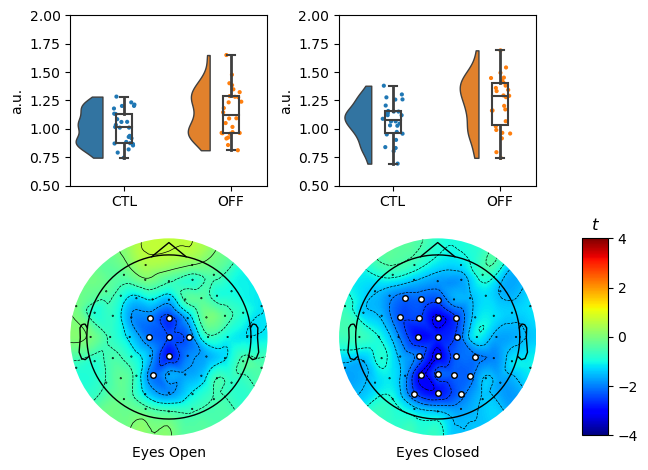

In [39]:
# =============================================================================
# Plot Exponents
# =============================================================================
#OFF vs CTL
EO_Obs = np.array(T_obs_eo_unmed.T)
EC_Obs = np.array(T_obs_ec_unmed.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  mask= np.array(clusters_eo_unmed[0].T), outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2 ,cmap='jet',  mask= np.array(clusters_ec_unmed[0].T), outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')

ax3 = fig.add_subplot(321)
pt.RainCloud(data=[cluster_aggregate(con_test_eo,clusters_eo_unmed[0].T),cluster_aggregate(unmed_test_eo,clusters_eo_unmed[0].T)], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[cluster_aggregate(con_test_ec,clusters_ec_unmed[0].T),cluster_aggregate(unmed_test_ec,clusters_ec_unmed[0].T)], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("a.u.")
fig.axes[4].get_yaxis().get_label().set_text("a.u.")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['CTL','OFF'])
fig.axes[4].set_xticklabels(['CTL','OFF'])
fig.axes[3].set_ylim([0.5,2])
fig.axes[4].set_ylim([0.5,2])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

CTL_UNMED_EXP_fig = fig


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':


<Figure size 640x480 with 0 Axes>

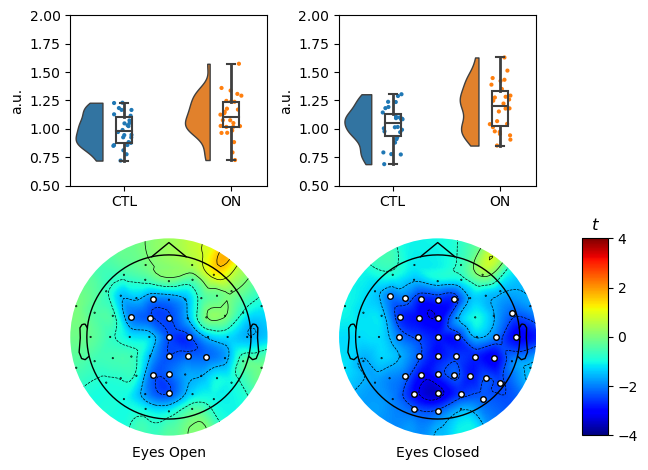

In [40]:
# %%% ON vs CTL
EO_Obs = np.array(T_obs_eo_med.T)
EC_Obs = np.array(T_obs_ec_med.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  mask= np.array(clusters_eo_med[0].T), outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  mask= np.array(clusters_ec_med[0].T), outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')


ax3 = fig.add_subplot(321)
pt.RainCloud(data=[cluster_aggregate(con_test_eo,clusters_eo_med[0].T),cluster_aggregate(med_test_eo,clusters_eo_med[0].T)], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[cluster_aggregate(con_test_ec,clusters_ec_med[0].T),cluster_aggregate(med_test_ec,clusters_ec_med[0].T)], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("a.u.")
fig.axes[4].get_yaxis().get_label().set_text("a.u.")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['CTL','ON'])
fig.axes[4].set_xticklabels(['CTL','ON'])
fig.axes[3].set_ylim([0.5,2])
fig.axes[4].set_ylim([0.5,2])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

CTL_MED_EXP_fig = fig

<Figure size 640x480 with 0 Axes>

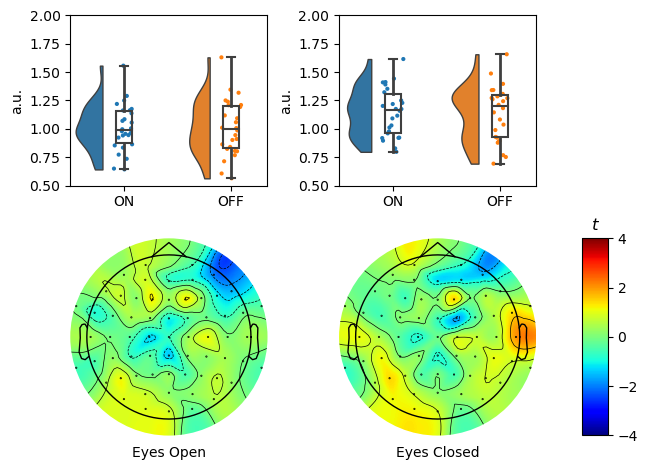

In [41]:
# %%% ON vs OFFs
EO_Obs = np.array(T_obs_eo_ws.T)
EC_Obs = np.array(T_obs_ec_ws.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',   outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')

ax3 = fig.add_subplot(321)
pt.RainCloud(data=[cluster_aggregate(med_test_eo,'none'),cluster_aggregate(unmed_test_eo,'none')], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[cluster_aggregate(med_test_ec,'none'),cluster_aggregate(unmed_test_ec,'none')], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("a.u.")
fig.axes[4].get_yaxis().get_label().set_text("a.u.")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['ON','OFF'])
fig.axes[4].set_xticklabels(['ON','OFF'])
fig.axes[3].set_ylim([0.5,2])
fig.axes[4].set_ylim([0.5,2])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

MED_UNMED_EXP_fig = fig


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':


<Figure size 640x480 with 0 Axes>

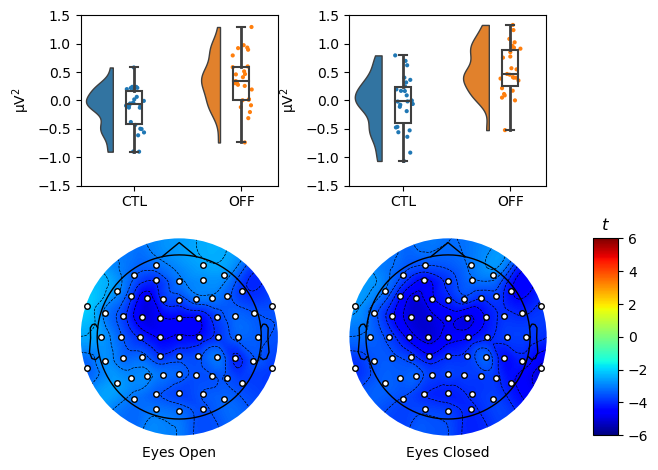

In [42]:
#Unmedicated vs control
EO_Obs = np.array(T_obs_o_eo_unmed.T)
EC_Obs = np.array(T_obs_o_ec_unmed.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  mask= np.array(clusters_o_eo_unmed[0].T), outlines = 'head',show=False, vlim=(-6,6))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  mask= np.array(clusters_o_ec_unmed[0].T), outlines = 'head',show=False, vlim=(-6,6))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')

ax3 = fig.add_subplot(321)
pt.RainCloud(data=[cluster_aggregate(con_test_o_eo,clusters_o_eo_unmed[0].T),cluster_aggregate(unmed_test_o_eo,clusters_o_eo_unmed[0].T)], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[cluster_aggregate(con_test_o_ec,clusters_o_ec_unmed[0].T),cluster_aggregate(unmed_test_o_ec,clusters_o_ec_unmed[0].T)], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['CTL','OFF'])
fig.axes[4].set_xticklabels(['CTL','OFF'])
fig.axes[3].set_ylim([-1.5,1.5])
fig.axes[4].set_ylim([-1.5,1.5])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

CTL_UNMED_OFF_fig = fig


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':


<Figure size 640x480 with 0 Axes>

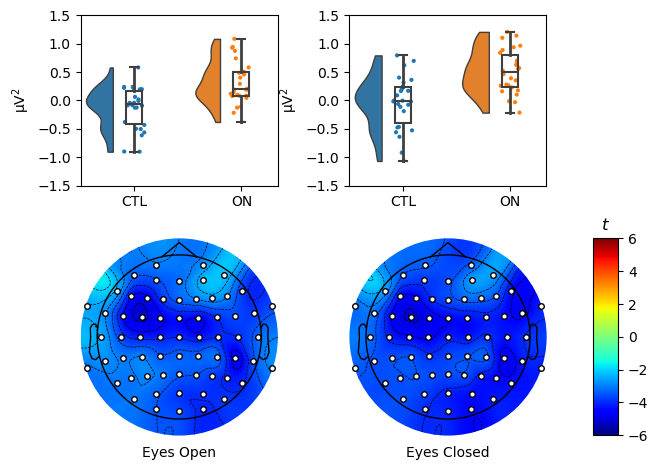

In [43]:
#medicated vs control
EO_Obs = np.array(T_obs_o_eo_med.T)
EC_Obs = np.array(T_obs_o_ec_med.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  mask= np.array(clusters_o_eo_med[0].T), outlines = 'head',show=False, vlim=(-6,6))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  mask= np.array(clusters_o_ec_med[0].T), outlines = 'head',show=False, vlim=(-6,6))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')


ax3 = fig.add_subplot(321)
pt.RainCloud(data=[cluster_aggregate(con_test_o_eo,clusters_o_eo_med[0].T),cluster_aggregate(med_test_o_eo,clusters_o_eo_med[0].T)], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[cluster_aggregate(con_test_o_ec,clusters_o_ec_med[0].T),cluster_aggregate(med_test_o_ec,clusters_o_ec_med[0].T)], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['CTL','ON'])
fig.axes[4].set_xticklabels(['CTL','ON'])
fig.axes[3].set_ylim([-1.5,1.5])
fig.axes[4].set_ylim([-1.5,1.5])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

CTL_MED_OFF_fig = fig

<Figure size 640x480 with 0 Axes>

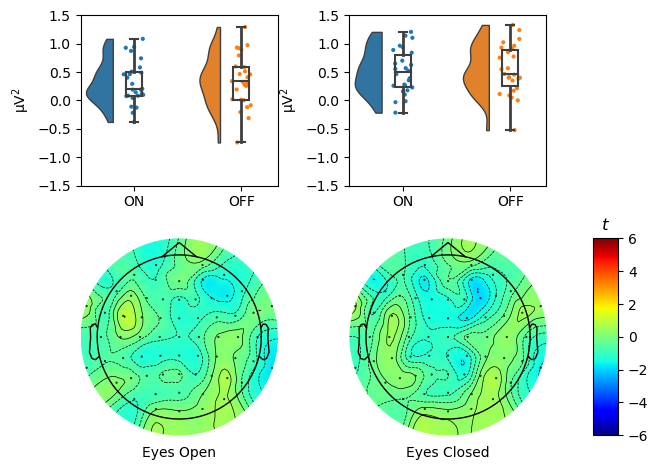

In [44]:
# %%% medicated vs unmedicated
EO_Obs = np.array(T_obs_o_eo_ws.T)
EC_Obs = np.array(T_obs_o_ec_ws.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  outlines = 'head',show=False, vlim=(-6,6))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  outlines = 'head',show=False, vlim=(-6,6))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')

ax3 = fig.add_subplot(321)
pt.RainCloud(data=[cluster_aggregate(med_test_o_eo,"none"),cluster_aggregate(unmed_test_o_eo,"none")], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[cluster_aggregate(med_test_o_ec,"none"),cluster_aggregate(unmed_test_o_ec,"none")], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['ON','OFF'])
fig.axes[4].set_xticklabels(['ON','OFF'])
fig.axes[3].set_ylim([-1.5,1.5])
fig.axes[4].set_ylim([-1.5,1.5])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

MED_UNMED_OFF_fig = fig

/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':


<Figure size 640x480 with 0 Axes>

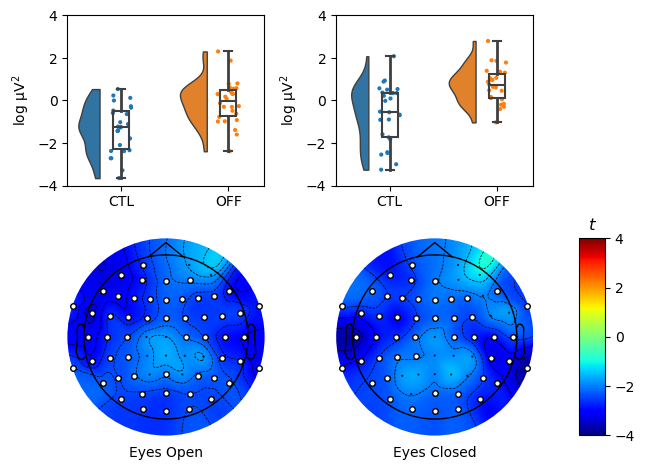

In [45]:

#%%%
# =============================================================================
# Plot Total Alpha
# =============================================================================

#Unmedicated vs control
EO_Obs = np.array(T_obs_alpha_eo_unmed.T)
EC_Obs = np.array(T_obs_alpha_ec_unmed.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  mask= np.array(clusters_alpha_eo_unmed[0].T), outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  mask= np.array(clusters_alpha_ec_unmed[0].T), outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')


ax3 = fig.add_subplot(321)
pt.RainCloud(data=[np.log(cluster_aggregate(con_test_alpha_eo,clusters_alpha_eo_unmed[0].T)),np.log(cluster_aggregate(unmed_test_alpha_eo,clusters_alpha_eo_unmed[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[np.log(cluster_aggregate(con_test_alpha_ec,clusters_alpha_ec_unmed[0].T)),np.log(cluster_aggregate(unmed_test_alpha_ec,clusters_alpha_ec_unmed[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("log $\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("log $\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['CTL','OFF'])
fig.axes[4].set_xticklabels(['CTL','OFF'])
fig.axes[3].set_ylim([-4,4])
fig.axes[4].set_ylim([-4,4])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

CTL_UNMED_TOT_ALPHA_fig = fig

/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':


<Figure size 640x480 with 0 Axes>

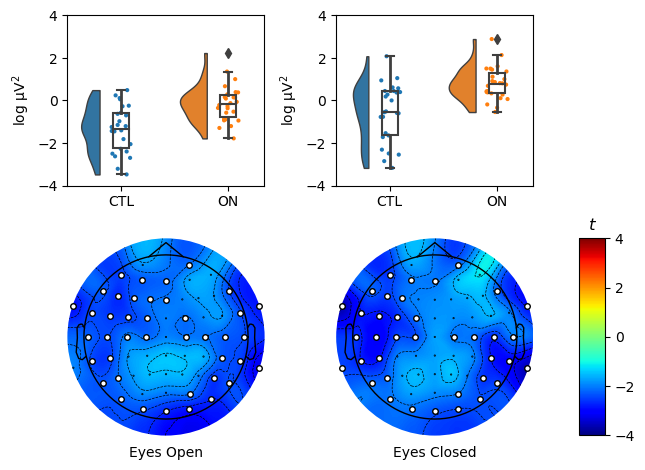

In [46]:
# %%% medicated vs control
EO_Obs = np.array(T_obs_alpha_eo_med.T)
EC_Obs = np.array(T_obs_alpha_ec_med.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  mask= np.array(clusters_alpha_eo_med[0].T), outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  mask= np.array(clusters_alpha_ec_med[0].T), outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')


ax3 = fig.add_subplot(321)
pt.RainCloud(data=[np.log(cluster_aggregate(con_test_alpha_eo,clusters_alpha_eo_med[0].T)),np.log(cluster_aggregate(med_test_alpha_eo,clusters_alpha_eo_med[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[np.log(cluster_aggregate(con_test_alpha_ec,clusters_alpha_ec_med[0].T)),np.log(cluster_aggregate(med_test_alpha_ec,clusters_alpha_ec_med[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("log $\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("log $\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['CTL','ON'])
fig.axes[4].set_xticklabels(['CTL','ON'])
fig.axes[3].set_ylim([-4,4])
fig.axes[4].set_ylim([-4,4])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

CTL_MED_TOT_ALPHA_fig = fig

<Figure size 640x480 with 0 Axes>

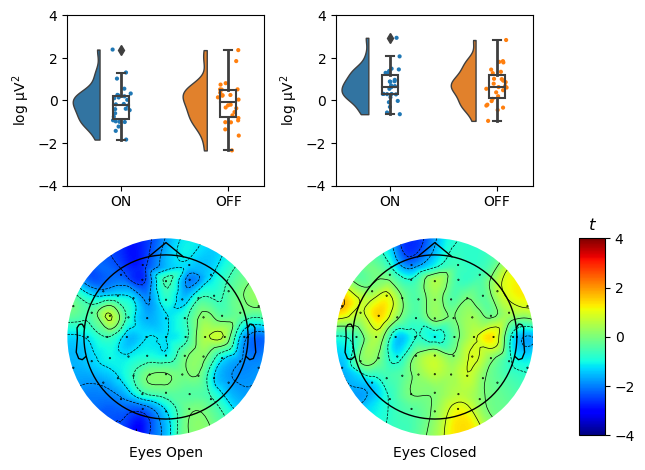

In [47]:
# %%% medicated vs unmedicated
EO_Obs = np.array(T_obs_eo_alpha_ws.T)
EC_Obs = np.array(T_obs_ec_alpha_ws.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')

ax3 = fig.add_subplot(321)
pt.RainCloud(data=[np.log(cluster_aggregate(med_test_alpha_eo,'none')),np.log(cluster_aggregate(unmed_test_alpha_eo,'none'))], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[np.log(cluster_aggregate(med_test_alpha_ec,'none')),np.log(cluster_aggregate(unmed_test_alpha_ec,'none'))], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("log $\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("log $\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['ON','OFF'])
fig.axes[4].set_xticklabels(['ON','OFF'])
fig.axes[3].set_ylim([-4,4])
fig.axes[4].set_ylim([-4,4])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

MED_UNMED_TOT_ALPHA_fig = fig

/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':


<Figure size 640x480 with 0 Axes>

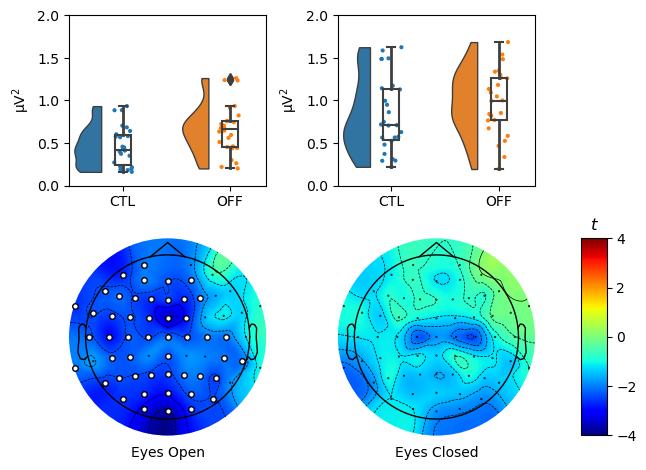

In [48]:
# %%
# =============================================================================
# Plot Relative Alpha
# =============================================================================

#Unmedicated vs control
EO_Obs = np.array(T_obs_cw_eo_unmed.T)
EC_Obs = np.array(T_obs_cw_ec_unmed.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  mask= np.array(clusters_cw_eo_unmed[0].T), outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')

ax3 = fig.add_subplot(321)
pt.RainCloud(data=[(cluster_aggregate(con_nans_eo,clusters_cw_eo_unmed[0].T)),(cluster_aggregate(unmed_nans_eo,clusters_cw_eo_unmed[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[(cluster_aggregate(con_nans_ec,'none')),(cluster_aggregate(unmed_nans_ec,'none'))], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['CTL','OFF'])
fig.axes[4].set_xticklabels(['CTL','OFF'])
fig.axes[3].set_ylim([0,2])
fig.axes[4].set_ylim([0,2])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

CTL_UNMED_REL_ALPHA_fig = fig


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':


<Figure size 640x480 with 0 Axes>

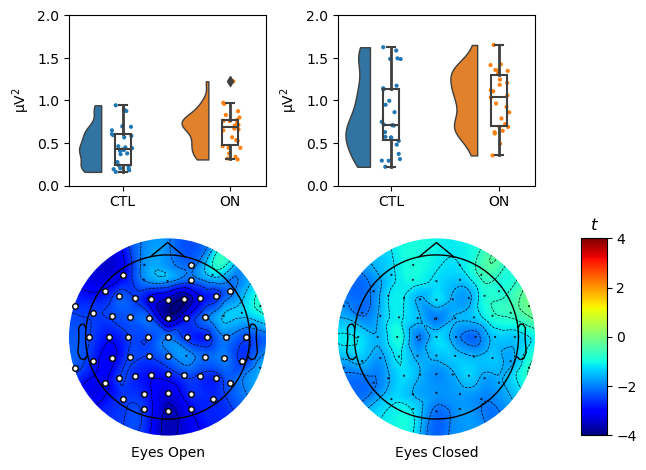

In [49]:
# %% medicated vs control
EO_Obs = np.array(T_obs_cw_eo_med.T)
EC_Obs = np.array(T_obs_cw_ec_med.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  mask= np.array(clusters_cw_eo_med[0].T), outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')

ax3 = fig.add_subplot(321)
pt.RainCloud(data=[(cluster_aggregate(con_nans_eo,clusters_cw_eo_med[0].T)),(cluster_aggregate(med_nans_eo,clusters_cw_eo_med[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[(cluster_aggregate(con_nans_ec,'none')),(cluster_aggregate(med_nans_ec,'none'))], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['CTL','ON'])
fig.axes[4].set_xticklabels(['CTL','ON'])
fig.axes[3].set_ylim([0,2])
fig.axes[4].set_ylim([0,2])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

CTL_MED_REL_ALPHA_fig = fig

<Figure size 640x480 with 0 Axes>

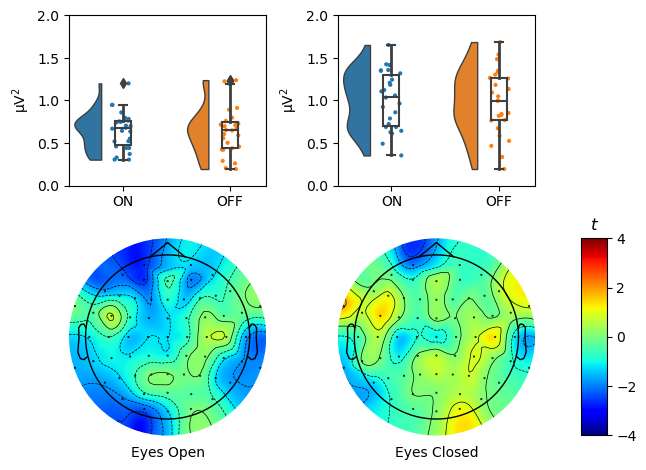

In [50]:
# %% medicated vs unmedicated
EO_Obs = np.array(T_obs_eo_alpha_ws.T)
EC_Obs = np.array(T_obs_ec_alpha_ws.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')

ax3 = fig.add_subplot(321)
pt.RainCloud(data=[(cluster_aggregate(med_nans_eo,'none')),(cluster_aggregate(unmed_nans_eo,'none'))], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[(cluster_aggregate(med_nans_ec,'none')),(cluster_aggregate(unmed_nans_ec,'none'))], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['ON','OFF'])
fig.axes[4].set_xticklabels(['ON','OFF'])
fig.axes[3].set_ylim([0,2])
fig.axes[4].set_ylim([0,2])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

MED_UNMED_REL_ALPHA_fig = fig

/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':


<Figure size 640x480 with 0 Axes>

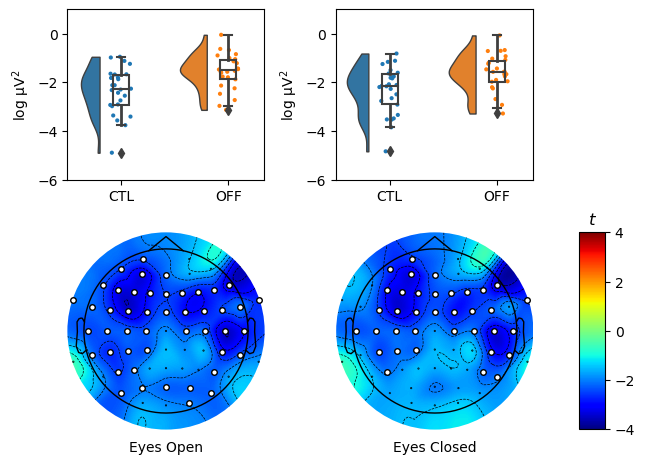

In [51]:
# %%
# =============================================================================
# Plot Total Beta
# =============================================================================

#Unmedicated vs control
EO_Obs = np.array(T_obs_beta_eo_unmed.T)
EC_Obs = np.array(T_obs_beta_ec_unmed.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  mask= np.array(clusters_beta_eo_unmed[0].T), outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  mask= np.array(clusters_beta_ec_unmed[0].T), outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')


ax3 = fig.add_subplot(321)
pt.RainCloud(data=[np.log(cluster_aggregate(con_test_beta_eo,clusters_beta_eo_unmed[0].T)),np.log(cluster_aggregate(unmed_test_beta_eo,clusters_beta_eo_unmed[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[np.log(cluster_aggregate(con_test_beta_ec,clusters_beta_ec_unmed[0].T)),np.log(cluster_aggregate(unmed_test_beta_eo,clusters_beta_ec_unmed[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("log $\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("log $\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['CTL','OFF'])
fig.axes[4].set_xticklabels(['CTL','OFF'])
fig.axes[3].set_ylim([-6,1])
fig.axes[4].set_ylim([-6,1])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

CTL_UNMED_TOT_BETA_fig = fig


/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':


<Figure size 640x480 with 0 Axes>

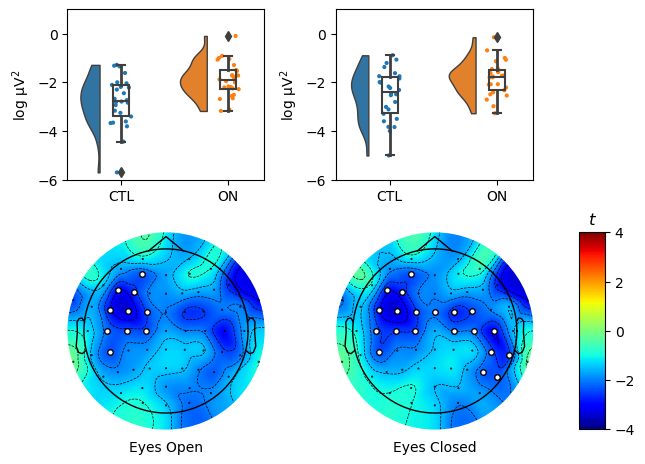

In [52]:
# %% medicated vs control
EO_Obs = np.array(T_obs_beta_eo_med.T)
EC_Obs = np.array(T_obs_beta_ec_med.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  mask= np.array(clusters_beta_eo_med[0].T), outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  mask= np.array(clusters_beta_ec_med[0].T), outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')

ax3 = fig.add_subplot(321)
pt.RainCloud(data=[np.log(cluster_aggregate(con_test_beta_eo,clusters_beta_eo_med[0].T)),np.log(cluster_aggregate(med_test_beta_eo,clusters_beta_eo_med[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[np.log(cluster_aggregate(con_test_beta_ec,clusters_beta_ec_med[0].T)),np.log(cluster_aggregate(med_test_beta_eo,clusters_beta_ec_med[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("log $\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("log $\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['CTL','ON'])
fig.axes[4].set_xticklabels(['CTL','ON'])
fig.axes[3].set_ylim([-6,1])
fig.axes[4].set_ylim([-6,1])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

CTL_MED_TOT_BETA_fig = fig

/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':


<Figure size 640x480 with 0 Axes>

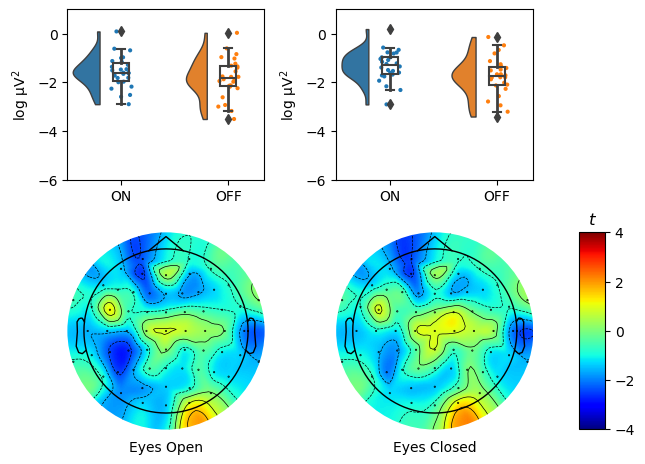

In [53]:
# %% medicated vs unmedicated
EO_Obs = np.array(T_obs_eo_beta_ws.T)
EC_Obs = np.array(T_obs_ec_beta_ws.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')


ax3 = fig.add_subplot(321)
pt.RainCloud(data=[np.log(cluster_aggregate(med_test_beta_eo,clusters_eo_beta_ws[0].T)),np.log(cluster_aggregate(unmed_test_beta_eo,clusters_beta_eo_med[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[np.log(cluster_aggregate(med_test_beta_ec,clusters_ec_beta_ws[0].T)),np.log(cluster_aggregate(unmed_test_beta_eo,clusters_beta_ec_med[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("log $\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("log $\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['ON','OFF'])
fig.axes[4].set_xticklabels(['ON','OFF'])
fig.axes[3].set_ylim([-6,1])
fig.axes[4].set_ylim([-6,1])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

MED_UNMED_TOT_BETA_fig = fig

/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':


<Figure size 640x480 with 0 Axes>

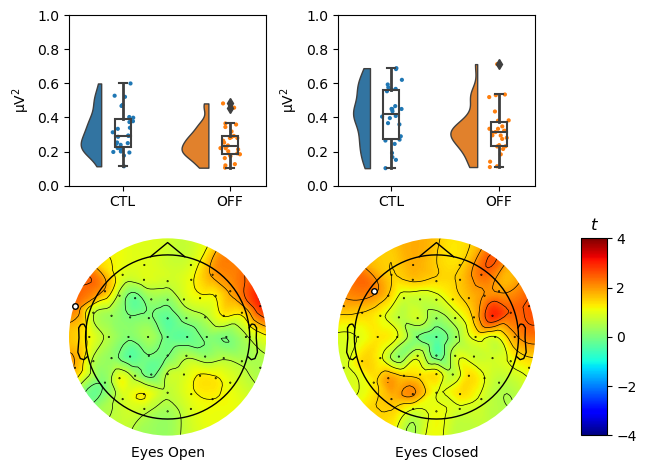

In [54]:
# =============================================================================
# Plot Relative beta
# =============================================================================

# %% Unmedicated vs control
EO_Obs = np.array(T_obs_bw_eo_unmed.T)
EC_Obs = np.array(T_obs_bw_ec_unmed.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  mask= np.array(clusters_bw_eo_unmed[0].T), outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  mask= np.array(clusters_bw_ec_unmed[0].T),outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')

ax3 = fig.add_subplot(321)
pt.RainCloud(data=[(cluster_aggregate(con_nans_bf_eo,clusters_bw_eo_unmed[0].T)),(cluster_aggregate(unmed_nans_bf_eo,clusters_bw_eo_unmed[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[(cluster_aggregate(con_nans_bf_ec,clusters_bw_ec_unmed[0].T)),(cluster_aggregate(unmed_nans_bf_ec,clusters_bw_ec_unmed[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['CTL','OFF'])
fig.axes[4].set_xticklabels(['CTL','OFF'])
fig.axes[3].set_ylim([0,1])
fig.axes[4].set_ylim([0,1])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

CTL_UNMED_REL_BETA_fig = fig

/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':
/var/folders/n8/txtqf2715w11h2b0g0xqfc040000gn/T/ipykernel_12067/3644173536.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask =='none':


<Figure size 640x480 with 0 Axes>

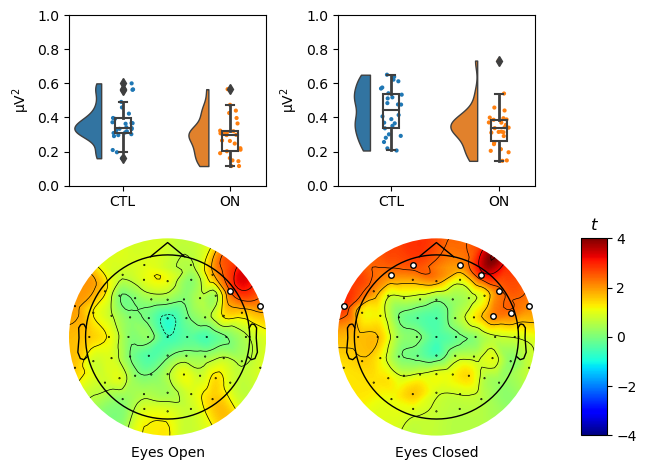

In [55]:
# %% medicated vs control
EO_Obs = np.array(T_obs_bw_eo_med.T)
EC_Obs = np.array(T_obs_bw_ec_med.T)

plt.figure(1,constrained_layout=True)
fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  mask= np.array(clusters_bw_eo_med[0].T), outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  mask= np.array(clusters_bw_ec_med[0].T),outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')

ax3 = fig.add_subplot(321)
pt.RainCloud(data=[(cluster_aggregate(con_nans_bf_eo,clusters_bw_eo_med[0].T)),(cluster_aggregate(med_nans_bf_eo,clusters_bw_eo_med[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[(cluster_aggregate(con_nans_bf_ec,clusters_bw_ec_med[0].T)),(cluster_aggregate(med_nans_bf_ec,clusters_bw_ec_med[0].T))], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['CTL','ON'])
fig.axes[4].set_xticklabels(['CTL','ON'])
fig.axes[3].set_ylim([0,1])
fig.axes[4].set_ylim([0,1])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

CTL_MED_REL_BETA_fig = fig

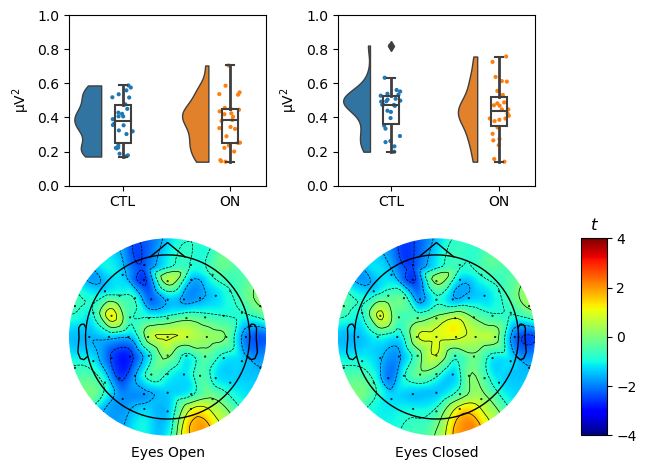

In [56]:
# %% medicated vs unmedicated
EO_Obs = np.array(T_obs_eo_beta_ws.T)
EC_Obs = np.array(T_obs_ec_beta_ws.T)

fig,(ax1,ax2) = plt.subplots(ncols=2)
im,cm = plot_topomap(EO_Obs[:,0], chan_info.info,axes=ax1, cmap='jet',  outlines = 'head',show=False, vlim=(-4,4))
im,cm = plot_topomap(EC_Obs[:,0], chan_info.info,axes=ax2,cmap='jet',  outlines = 'head',show=False, vlim=(-4,4))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.5

cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('t',fontsize=12,fontstyle='italic')

ax3 = fig.add_subplot(321)
pt.RainCloud(data=[(cluster_aggregate(med_nans_bf_eo,"none")),(cluster_aggregate(unmed_nans_bf_eo,"none"))], bw= .4, width_viol = .5,palette ="tab10",point_size = 3,pointplot = False)

ax4 = fig.add_subplot(322,sharex=ax3)
pt.RainCloud(data=[(cluster_aggregate(med_nans_bf_ec,"none")),(cluster_aggregate(unmed_nans_bf_ec,"none"))], bw= .4, width_viol = .5,palette ="tab10",point_size= 3,pointplot = False)

fig.axes[3].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[4].get_yaxis().get_label().set_text("$\mathregular{µV^2}$")
fig.axes[0].get_xaxis().get_label().set_text("Eyes Open")
fig.axes[1].get_xaxis().get_label().set_text("Eyes Closed")
fig.axes[3].set_xticklabels(['CTL','ON'])
fig.axes[4].set_xticklabels(['CTL','ON'])
fig.axes[3].set_ylim([0,1])
fig.axes[4].set_ylim([0,1])

fig.patch.set_facecolor('white')
fig.axes[0].set_position([0, 0.069134, 0.308194, 0.410925])
fig.axes[1].set_position([0.42, 0.069134, 0.308194, 0.410925])
fig.axes[2].set_position([0.8, 0.069955, 0.039985, 0.410105])
fig.axes[3].set_position([0, 0.590038, 0.307813, 0.354583])
fig.axes[4].set_position([0.42, 0.590038, 0.307813, 0.354583])

MED_UNMED_REL_BETA_fig = fig

In [ ]:
# %%% Save figures
CTL_UNMED_EXP_fig.savefig("CTL_UNMED_EXP",bbox_inches='tight',dpi = 720,facecolor='white')
CTL_MED_EXP_fig.savefig("CTL_MED_EXP",bbox_inches='tight',dpi = 720,facecolor='white')
MED_UNMED_EXP_fig.savefig("MED_UNMED_EXP",bbox_inches='tight',dpi = 720,facecolor='white')

CTL_UNMED_OFF_fig.savefig("CTL_UNMED_OFF",bbox_inches='tight',dpi = 720,facecolor='white')
CTL_MED_OFF_fig.savefig("CTL_MED_OFF",bbox_inches='tight',dpi = 720,facecolor='white')
MED_UNMED_OFF_fig.savefig("MED_UNMED_OFF",bbox_inches='tight',dpi = 720,facecolor='white')

CTL_UNMED_TOT_ALPHA_fig.savefig("CTL_UNMED_TOT_ALPHA",bbox_inches='tight',dpi = 720,facecolor='white')
CTL_MED_TOT_ALPHA_fig.savefig("CTL_MED_TOT_ALPHA",bbox_inches='tight',dpi = 720,facecolor='white')
MED_UNMED_TOT_ALPHA_fig.savefig("MED_UNMED_TOT_ALPHA",bbox_inches='tight',dpi = 720,facecolor='white')

CTL_UNMED_TOT_BETA_fig.savefig("CTL_UNMED_TOT_BETA",bbox_inches='tight',dpi = 720,facecolor='white')
CTL_MED_TOT_BETA_fig.savefig("CTL_MED_TOT_BETA",bbox_inches='tight',dpi = 720,facecolor='white')
MED_UNMED_TOT_BETA_fig.savefig("MED_UNMED_TOT_BETA",bbox_inches='tight',dpi = 720,facecolor='white')

CTL_UNMED_REL_ALPHA_fig.savefig("CTL_UNMED_REL_ALPHA",bbox_inches='tight',dpi = 720,facecolor='white')
CTL_MED_REL_ALPHA_fig.savefig("CTL_MED_REL_ALPHA",bbox_inches='tight',dpi = 720,facecolor='white')
MED_UNMED_REL_ALPHA_fig.savefig("MED_UNMED_REL_ALPHA",bbox_inches='tight',dpi = 720,facecolor='white')

CTL_UNMED_REL_BETA_fig.savefig("CTL_UNMED_REL_BETA",bbox_inches='tight',dpi = 720,facecolor='white')
CTL_MED_REL_BETA_fig.savefig("CTL_MED_REL_BETA",bbox_inches='tight',dpi = 720,facecolor='white')
MED_UNMED_REL_BETA_fig.savefig("MED_UNMED_REL_BETA",bbox_inches='tight',dpi = 720,facecolor='white')